Images and metadata: https://drive.google.com/file/d/1h91HNUN5UBE6CexoxI_eXIb-KSDZk85m/view?usp=sharing

In [2]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D,MaxPooling2D, Dropout, Flatten,GlobalAveragePooling2D,BatchNormalization
from keras.models import Model
from keras.layers import Input
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
from matplotlib.pyplot import imshow
from sklearn.metrics import confusion_matrix, classification_report,roc_curve,auc,roc_auc_score
import itertools
from keras import backend as K
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator,array_to_img, img_to_array, load_img
from livelossplot import PlotLossesKeras
import keras
#from keras.applications import InceptionV3, MobileNet
from keras.models import load_model
from keras.optimizers import Adam
import keras_metrics as km
from keras.callbacks import ModelCheckpoint, Callback
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import StratifiedKFold
from IPython.display import Audio
from sklearn.utils import resample
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import precision_recall_curve
from keras import applications
sound_file = 'https://www.soundjay.com/button/beep-07.wav'


Using TensorFlow backend.


### Loading and Pre-Processing Data

In [2]:
# set our input dimensions - can be changed later
input_dims = (200,200)

#set directory of images
impath = r'C:\Users\Admin\Downloads\skin-cancer-mnist-ham100002'

This function will set up a some dictionaries and add the info to the metadata csv accompanying the images. Details in comments below:

In [3]:
def create_df(path,input_dims):
    
    # create a dictionary of key: image ID and value: path to image
    imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in glob(os.path.join(impath, '*.jpg'))}

    # Create a dctionary of labels used for mapping later - 1 for melanoma, 0 for everything else
    lesion_class_dict = {
        'nv': '0',
        'mel': '1',
        'bkl': '0',
        'bcc': '0',
        'akiec': '0',
        'vasc': '0',
        'df': '0'
    }
    
    # create a another dictionary for mapping of dataset names and corresponding full names from HAM1000 paper
    lesion_name_dict = {
        'nv': 'Melanocytic nevi',
        'mel': 'Melanoma',
        'bkl': 'Benign keratosis-like lesions ',
        'bcc': 'Basal cell carcinoma',
        'akiec': 'Actinic keratoses',
        'vasc': 'Vascular lesions',
        'df': 'Dermatofibroma'
    }
    
    # Read in the metadata csv HAM10000
    df = pd.read_csv(os.path.join(path, 'HAM10000_metadata.csv'))
    
    
    # Create some new columns in the metadata using the dictionaries above: path to image on disk, class of lesion, and lesion name
    df['path'] = df['image_id'].map(imageid_path_dict.get)
    df['class'] = df['dx'].map(lesion_class_dict.get) 
    df['lesion_name'] = df['dx'].map(lesion_name_dict.get)
    

    # loading image arrays into newly created 'image' column

    df['image'] = df['path'].map(lambda x: np.asarray(Image.open(x).resize(input_dims)))
    
    
    # =============================================================================
    #     NEW IMAGE DATA - 500 EXTRA MELANOMA
    # =============================================================================
    
    # directory of new images
    newdir = r'C:\Users\Admin\Downloads\Extra Melanoma\Selection'
    
    # get list of images in dir
    new_im_list = os.listdir(r'C:\Users\Admin\Downloads\Extra Melanoma\Selection')
    
    # lisht
    new_ims=[]
    
    # resize to input dims and append
    for f in new_im_list:
        x = np.asarray(Image.open(os.path.join(newdir,f)).resize(input_dims))
        new_ims.append(x)
    
    # convert to df
    z = pd.DataFrame({'image':new_ims})
    
    # they're all melanoma = class 1
    z['class']='1'
    
    # concat two dfs 
    df=pd.concat([df,z],sort=True)
    
    df = df[['image','class']]
    
    return df

Now that the function is set up we can load and map all data including images to the metadata CSV. This loads and resizes over 10,000 images - takes about 2 minutes.

In [3]:


#df = create_df(impath,input_dims)

# code below to save and load pickled dataframes - saves time 

#df.to_pickle(r'C:\Users\Admin\OneDrive - mycit.ie\Documents\CIT\Semester 2\Final Project\PW Submission 1\200_200_new_ims.pkl')
df=pd.read_pickle(r'C:\Users\Admin\OneDrive - mycit.ie\Documents\CIT\Semester 2\Final Project\PW Submission 1\200_200_new_ims.pkl')

Next step is to create a train test split function.

In [5]:
def train_test(df):
    
    x_train, x_test, y_train, y_test = train_test_split(df['image'], df['class'], test_size=0.2,random_state=5)


    #what's the training set split like? IMBALANCED
    
    print('Training set balance:\n',y_train.value_counts())
    print('Test set balance:\n',y_test.value_counts())
    
    
    x_train = np.asarray(x_train.tolist())
    x_test = np.asarray(x_test.tolist())
    y_train = np.asarray(y_train.tolist(),dtype=np.uint8)
    y_test = np.asarray(y_test.tolist(),dtype=np.uint8)   
    
    
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    
    return x_train, x_test, y_train, y_test

Now set up three types of normalizing functions to test - zscore, maxmin and dividing by total number of pixels

In [6]:
def norm_z(xtrain,xtest):
    
    # standardizes image arrays by subtracting mean and dividing by std dev
    x = (xtrain - xtrain.mean())/xtrain.std()
    y = (xtest - xtrain.mean())/xtrain.std()
    
    return x,y

def norm_maxmin(xtrain,xtest):
    x = (xtrain-np.min(xtrain))/(np.max(xtrain)-np.min(xtrain))
    y = (xtest-np.min(xtrain))/(np.max(xtrain)-np.min(xtrain))

    return x,y
    
def norm_255(xtrain,xtest):
    x = xtrain/255.0
    y = xtest/255.0
    
    return x,y   

### Model Creation Function

In [7]:
# custom keras metric for tracking AUC

def auroc(y_true, y_pred):
    return tf.py_func(roc_auc_score, (y_true, y_pred), tf.double)

In [7]:
def createModel(input_shape,num_classes):

    
    model = Sequential()

    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    

    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
        
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    
    model.add(MaxPool2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    
    model.add(Dense(num_classes, activation='sigmoid'))
    
    #adam = Adam(lr=0.0001)
    #adam = Adam(lr=1e-3, decay=1e-3 / 200)
    
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=[auroc,km.binary_precision(), km.binary_recall(),km.binary_f1_score()])
    
    return model

### Model Evaluation Function

Two functions to evaluate the model once trained: Single confusion matrix function and more indepth model evaluation function

Confusion Matrix Function:

In [8]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    print('Confusion matrix')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Evaluation function which calls the confusion matrix function:

In [9]:
def get_stats(model,history,x_test,y_test):
    
    # compuiting test loss and accuracy

    score = model.evaluate(x_test, y_test, verbose=1)
    #model.metrics_names
    
    print('\nValidation loss:', score[0])
    print('Validation auc:', score[1])
    print('Validation precision:',score[2])
    print('Validation recall:',score[3],)
    print('Validation F Score:',score[4],'\n')
    
    class_names = ['Melanoma','Non Melanoma']
    
    # getting the predicted probabilities and classes

    y_pred = model.predict_classes(x_test) 
    y_prob = model.predict(x_test)

    # determine threshold and get new updated class
    #ypred_classes=y_prob>0.5
    
    print(classification_report(y_test, y_pred,target_names=['Non Melanoma','Melanoma'],digits=2))
    
    cm=confusion_matrix(y_test,y_pred,labels=[1,0])

    # calling the confusion matrix function from earlier to display a plot
    
    np.set_printoptions(precision=2)
    plt.figure()
    plot_confusion_matrix(cm,class_names,
                          title='Confusion matrix')
    plt.show()
  
    fig = plt.figure(figsize=(13,10))
    # Plot training & validation accuracy values
    plt.subplot(2, 2, 1)
    plt.plot(history.history['recall'])
    plt.plot(history.history['val_recall'])
    plt.title('Recall')
    plt.ylabel('Recall')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    
    
    # Plot training & validation accuracy values
    plt.subplot(2, 2, 2)
    plt.plot(history.history['precision'])
    plt.plot(history.history['val_precision'])
    plt.title('Precision')
    plt.ylabel('Precision')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    
    
    # Plot training & validation loss values
    plt.subplot(2, 2, 3)
    plt.plot(history.history['f1_score'])
    plt.plot(history.history['val_f1_score'])
    plt.title('F Score')
    plt.ylabel('F Score')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    
    
    # Plot training & validation loss values
    plt.subplot(2, 2, 4)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
        
        
    fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_prob)
    auc_keras = auc(fpr_keras, tpr_keras)
    
    plt.figure(figsize=(7,7))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_keras, tpr_keras, label='AUC (area = {:.3f})'.format(score[1]))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('CNN ROC curve')
    plt.legend(loc='best')
    plt.show()
    
    precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
    # calculate precision-recall AUC
    aucp = auc(recall, precision)
    
    plt.figure(figsize=(7,7))
    plt.plot(recall, precision, label='AUC (area = {:.3f})'.format(aucp))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision Recall Curve')
    plt.legend(loc='best')
    plt.show()

### Evaluation function that takes a specified threshold for converting probs to classification.

In [9]:
def get_stats_thresh(model,history,x_test,y_test,thresh):
    
    # compuiting test loss and accuracy

    score = model.evaluate(x_test, y_test, verbose=1)
    #model.metrics_names
    
    print('\nValidation loss:', score[0])
    print('Validation auc:', score[1])
    print('Validation precision:',score[2])
    print('Validation recall:',score[3],)
    print('Validation F Score:',score[4],'\n')
    
    class_names = ['Melanoma','Non Melanoma']
    
    # getting the predicted probabilities and classes

    y_pred = model.predict(x_test) >= thresh
    y_prob = model.predict(x_test)

    # determine threshold and get new updated class
    #ypred_classes=y_prob>0.5
    
    print(classification_report(y_test, y_pred,target_names=['Non Melanoma','Melanoma'],digits=2))
    
    cm=confusion_matrix(y_test,y_pred,labels=[1,0])

    # calling the confusion matrix function from earlier to display a plot
    
    np.set_printoptions(precision=2)
    plt.figure()
    plot_confusion_matrix(cm,class_names,
                          title='Confusion matrix')
    plt.show()
  
    fig = plt.figure(figsize=(13,10))
    # Plot training & validation accuracy values
    plt.subplot(2, 2, 1)
    plt.plot(history.history['recall'])
    plt.plot(history.history['val_recall'])
    plt.title('Recall')
    plt.ylabel('Recall')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    
    
    # Plot training & validation accuracy values
    plt.subplot(2, 2, 2)
    plt.plot(history.history['precision'])
    plt.plot(history.history['val_precision'])
    plt.title('Precision')
    plt.ylabel('Precision')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    
    
    # Plot training & validation loss values
    plt.subplot(2, 2, 3)
    plt.plot(history.history['f1_score'])
    plt.plot(history.history['val_f1_score'])
    plt.title('F Score')
    plt.ylabel('F Score')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    
    
    # Plot training & validation loss values
    plt.subplot(2, 2, 4)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
        
        
    fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_prob)
    auc_keras = auc(fpr_keras, tpr_keras)
    
    plt.figure(figsize=(7,7))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_keras, tpr_keras, label='AUC (area = {:.3f})'.format(score[1]))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('CNN ROC curve')
    plt.legend(loc='best')
    plt.show()
    
    precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
    # calculate precision-recall AUC
    aucp = auc(recall, precision)
    
    plt.figure(figsize=(7,7))
    plt.plot(recall, precision, label='AUC (area = {:.3f})'.format(aucp))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision Recall Curve')
    plt.legend(loc='best')
    plt.show()

### Model Training

We now have our dataframe 'df' which has all the images in the ['image'] column, and all necessary functiions set up.  The cell below will initialize some parameters, create the train test split, normalize it, create the model, train it then evaluate it. Various custom metrics have been set up - auc, fscore, recall and precision. These can be tracked and used for early stopping, learning rate adjustment or model checkpoints. 

#### Base Model - with no augmentation

Very volatile training curves - even with learning rate anealer. Low recall out of the box - next is image augmentation.

First set up some parameters and carry out the train test split:

In [11]:
batch_size = 128
epochs = 50
num_classes = 1
input_shape = input_dims + (3,)
class_weights={0: 1, 1: 4}  

xtrain, xtest, ytrain, ytest = train_test(df)

# dataframe no longer needed
del df

    
#choose the type of normalization using the functions. Could also choose not to normalize it at all.
# norm_z(xtrain,xtest)
# norm_maxmin(xtrain,xtest)
# norm_255(xtrain,xtest)

xtrain,xtest = norm_255(xtrain,xtest)

# increase class weights of melanoma (class 1) as this is a highly imbalanced class
#class_weights=np.array([ 4.38673342,0.56432137])
  
# train model

Training set balance:
 0    7116
1    1289
Name: class, dtype: int64
Test set balance:
 0    1786
1     316
Name: class, dtype: int64


In [12]:
%%time


#create model
model1 = createModel(input_shape,num_classes)

history1 = model1.fit(xtrain, ytrain,
    batch_size=batch_size,
    class_weight=class_weights,
    epochs=epochs,
    verbose=1,
    validation_data=(xtest, ytest))

Audio(sound_file, autoplay=True)

NameError: name 'createModel' is not defined

2102/2102 [==============================] - 4s 2ms/step

Validation loss: 0.7110161013426268
Validation auc: 0.8473399578203323
Validation precision: 0.5015290518343949
Validation recall: 0.5189873416079155
Validation F Score: 0.5101088145527068 

              precision    recall  f1-score   support

Non Melanoma       0.91      0.91      0.91      1786
    Melanoma       0.50      0.52      0.51       316

 avg / total       0.85      0.85      0.85      2102

Confusion matrix


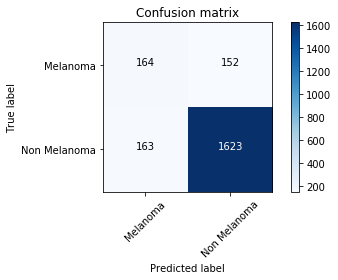

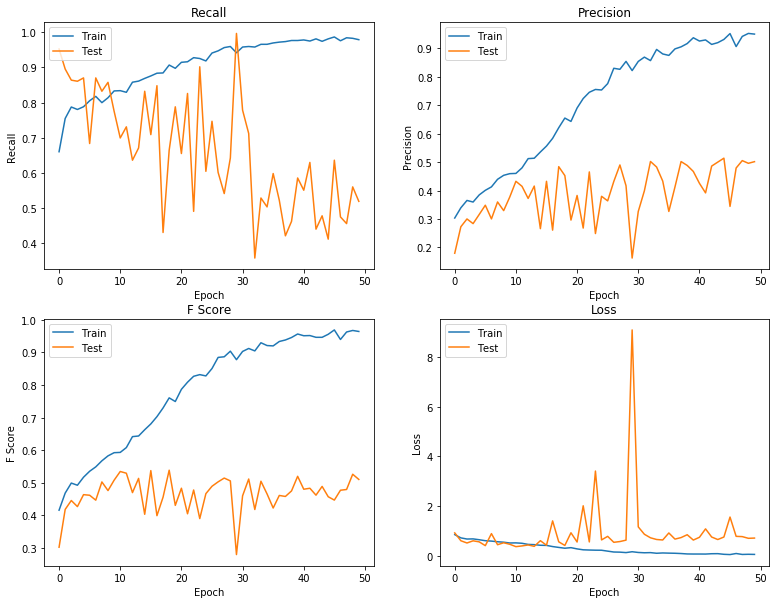

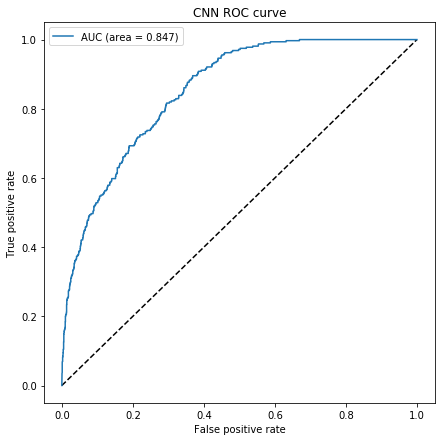

In [20]:
# evaluate
get_stats(model1,history1,xtest,ytest)

#### Now with image augmentation

None of these augmentations will affect the shape or appearance of the lesion - they are simple transformations such as zoom and shift left/right. Checkpoints will be created based on highest AUC. 

In [22]:
%%time

# same batch size and epochs

model = createModel(input_shape,num_classes)

datagen = ImageDataGenerator(
    zoom_range=0.2,          # randomly zoom into images
    rotation_range=90,      # randomly rotate images in the range (degrees, 0 to 180). 
    width_shift_range=0.1,   # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,    # randomly flip images
    vertical_flip=True)      # randomly flip images


# set up model checkpoint
#save_dir = r'C:\Users\Admin\OneDrive - mycit.ie\Documents\CIT\Semester 2\Final Project\Latest Models\Saved_Mods'
save_path = 'Best_AUC.hdf5'

# save highest AUC out of all epochs (can also monitor recall,precision and f-score)
checkpoint = ModelCheckpoint(save_path, monitor='val_auroc', verbose=1, save_best_only=True, mode='max')

# reduce learning rate if AUC stagnates
reduce_lr = ReduceLROnPlateau(monitor='val_auroc', factor=0.2,patience=5, min_lr=0.0001)

# Fit the model on the images
history = model.fit_generator(datagen.flow(xtrain, ytrain, batch_size=batch_size),
                                steps_per_epoch=int(np.ceil(xtrain.shape[0] / float(batch_size))),
                                epochs=epochs,
                                class_weight={0: 1, 1: 4},
                                validation_data=(xtest, ytest),
                                callbacks=[checkpoint,reduce_lr],
                                workers=7)

Audio(sound_file, autoplay=True)

Epoch 1/50
66/66 [==============================] - 39s 586ms/step - loss: 0.8296 - auroc: 0.7853 - precision: 0.3146 - recall: 0.6816 - f1_score: 0.4305 - val_loss: 1.4726 - val_auroc: 0.7546 - val_precision: 0.1832 - val_recall: 0.9715 - val_f1_score: 0.3082

Epoch 00001: val_auroc improved from -inf to 0.75461, saving model to Best_AUC.hdf5
Epoch 2/50
66/66 [==============================] - 42s 634ms/step - loss: 0.7347 - auroc: 0.8238 - precision: 0.3338 - recall: 0.7153 - f1_score: 0.4552 - val_loss: 0.5145 - val_auroc: 0.7733 - val_precision: 0.3006 - val_recall: 0.5918 - val_f1_score: 0.3987

Epoch 00002: val_auroc improved from 0.75461 to 0.77334, saving model to Best_AUC.hdf5
Epoch 3/50
66/66 [==============================] - 43s 645ms/step - loss: 0.7079 - auroc: 0.8364 - precision: 0.3437 - recall: 0.7665 - f1_score: 0.4745 - val_loss: 0.6560 - val_auroc: 0.7963 - val_precision: 0.2636 - val_recall: 0.9019 - val_f1_score: 0.4080

Epoch 00003: val_auroc improved from 0.7733


Epoch 00025: val_auroc did not improve from 0.88289
Epoch 26/50
66/66 [==============================] - 42s 638ms/step - loss: 0.5651 - auroc: 0.8998 - precision: 0.4344 - recall: 0.8138 - f1_score: 0.5664 - val_loss: 0.3977 - val_auroc: 0.8761 - val_precision: 0.3860 - val_recall: 0.7880 - val_f1_score: 0.5182

Epoch 00026: val_auroc did not improve from 0.88289
Epoch 27/50
66/66 [==============================] - 42s 632ms/step - loss: 0.5673 - auroc: 0.8993 - precision: 0.4331 - recall: 0.8185 - f1_score: 0.5664 - val_loss: 0.4034 - val_auroc: 0.8795 - val_precision: 0.3774 - val_recall: 0.8133 - val_f1_score: 0.5155

Epoch 00027: val_auroc did not improve from 0.88289
Epoch 28/50
66/66 [==============================] - 44s 659ms/step - loss: 0.5615 - auroc: 0.8993 - precision: 0.4335 - recall: 0.8068 - f1_score: 0.5640 - val_loss: 0.3618 - val_auroc: 0.8853 - val_precision: 0.4177 - val_recall: 0.7785 - val_f1_score: 0.5436

Epoch 00028: val_auroc improved from 0.88289 to 0.8852

#### Load best checkpoint and evaluate the model:

2102/2102 [==============================] - 4s 2ms/step

Validation loss: 0.3449074522468955
Validation auc: 0.889947655914797
Validation precision: 0.44760213135921806
Validation recall: 0.7974683541780164
Validation F Score: 0.5733787934080677 

              precision    recall  f1-score   support

Non Melanoma       0.96      0.83      0.89      1786
    Melanoma       0.45      0.80      0.57       316

 avg / total       0.88      0.82      0.84      2102

Confusion matrix


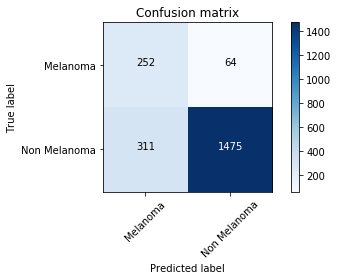

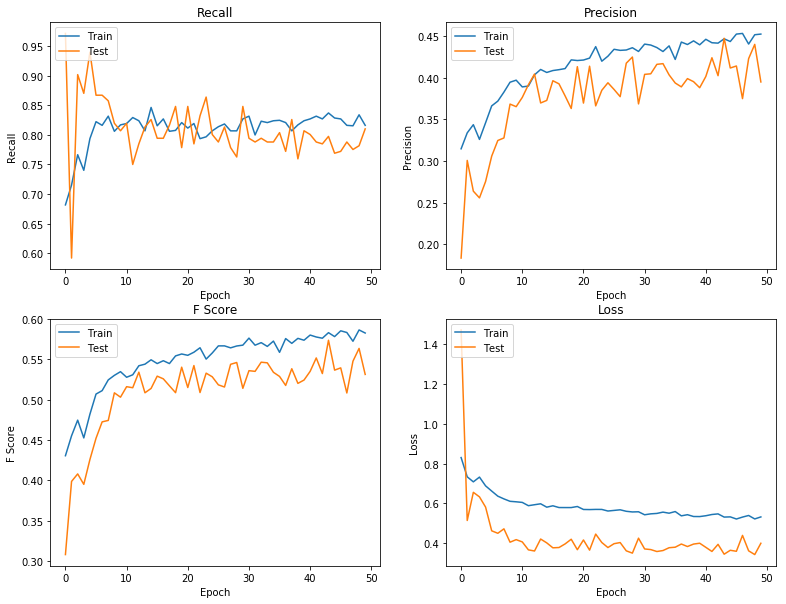

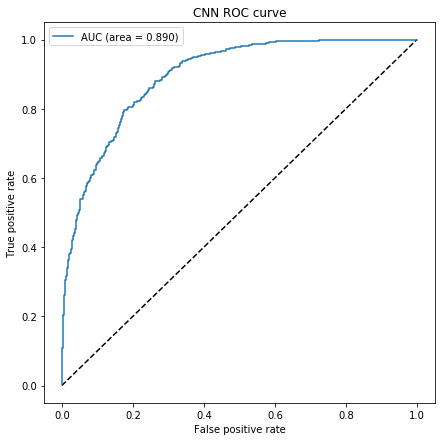

In [23]:
# reload best model - initialize model again
model = createModel(input_shape,num_classes)

#load weights
model.load_weights('Best_AUC.hdf5')
get_stats(model,history,xtest,ytest)

#### Other areas to investigate:

 - Another method of adjusting weights: Focal loss, which reduces the weights of well classified examples. This focuses the training on data that is harder to classify. https://towardsdatascience.com/handling-imbalanced-datasets-in-deep-learning-f48407a0e758
 
 - Learning rate annealer / decay
 
 - Add more dropout to model - reduce overfitting
 
 - Transfer learning - VGGNet
 
 - Autocropping images - see autocrop code in repository
 
 - I have sourced 1,000 extra melanoma images. Will need to develop a method of splicing them into the above dataset. 
 

Remove sets of Conv,Batch and Maxpool starting from Flatten() 

In [25]:
def createModel2(input_shape,num_classes):

    
    model = Sequential()

    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Flatten())
    
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    
    model.add(Dense(num_classes, activation='sigmoid'))
    
    #adam = Adam(lr=0.0001)
    #adam = Adam(lr=1e-3, decay=1e-3 / 200)
    
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=[auroc,km.binary_precision(), km.binary_recall(),km.binary_f1_score()])
    
    return model

Epoch 1/50
66/66 [==============================] - 38s 570ms/step - loss: 1.0241 - auroc: 0.7629 - precision: 0.2874 - recall: 0.6183 - f1_score: 0.3924 - val_loss: 0.7817 - val_auroc: 0.8053 - val_precision: 0.2769 - val_recall: 0.8386 - val_f1_score: 0.4163

Epoch 00001: val_auroc improved from -inf to 0.80530, saving model to Best_AUC.hdf5
Epoch 2/50
66/66 [==============================] - 40s 602ms/step - loss: 0.8094 - auroc: 0.8029 - precision: 0.3212 - recall: 0.6959 - f1_score: 0.4395 - val_loss: 0.4296 - val_auroc: 0.8096 - val_precision: 0.3496 - val_recall: 0.6361 - val_f1_score: 0.4512

Epoch 00002: val_auroc improved from 0.80530 to 0.80965, saving model to Best_AUC.hdf5
Epoch 3/50
66/66 [==============================] - 40s 600ms/step - loss: 0.7492 - auroc: 0.8204 - precision: 0.3209 - recall: 0.7548 - f1_score: 0.4504 - val_loss: 1.1209 - val_auroc: 0.7701 - val_precision: 0.1934 - val_recall: 0.9652 - val_f1_score: 0.3222

Epoch 00003: val_auroc did not improve from


Epoch 00025: val_auroc improved from 0.87893 to 0.87954, saving model to Best_AUC.hdf5
Epoch 26/50
66/66 [==============================] - 41s 617ms/step - loss: 0.5828 - auroc: 0.8934 - precision: 0.4048 - recall: 0.8448 - f1_score: 0.5474 - val_loss: 0.3780 - val_auroc: 0.8782 - val_precision: 0.3911 - val_recall: 0.8070 - val_f1_score: 0.5269

Epoch 00026: val_auroc did not improve from 0.87954
Epoch 27/50
66/66 [==============================] - 41s 626ms/step - loss: 0.5853 - auroc: 0.8914 - precision: 0.3989 - recall: 0.8340 - f1_score: 0.5397 - val_loss: 0.4126 - val_auroc: 0.8797 - val_precision: 0.3624 - val_recall: 0.8671 - val_f1_score: 0.5112

Epoch 00027: val_auroc improved from 0.87954 to 0.87971, saving model to Best_AUC.hdf5
Epoch 28/50
66/66 [==============================] - 41s 621ms/step - loss: 0.5814 - auroc: 0.8926 - precision: 0.4107 - recall: 0.8115 - f1_score: 0.5454 - val_loss: 0.4550 - val_auroc: 0.8672 - val_precision: 0.3570 - val_recall: 0.8608 - val_f1

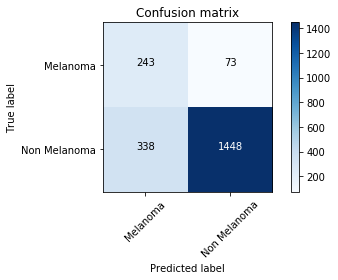

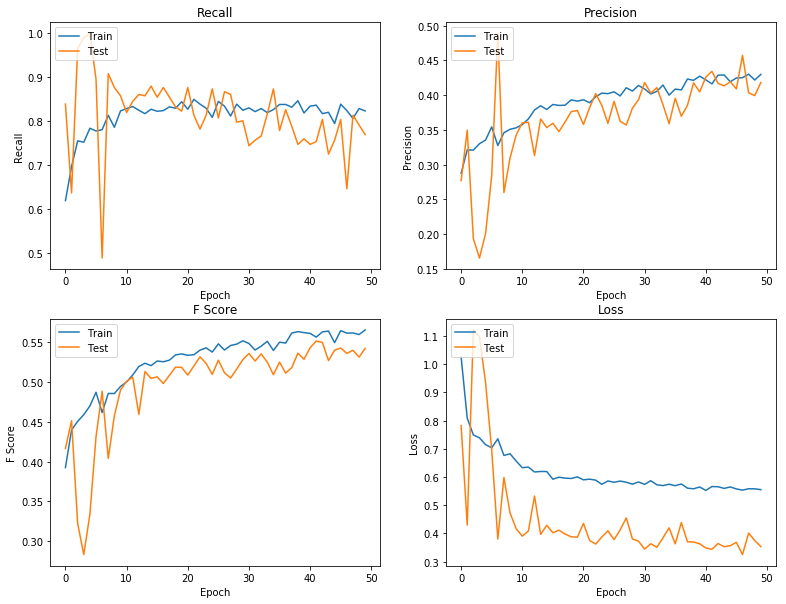

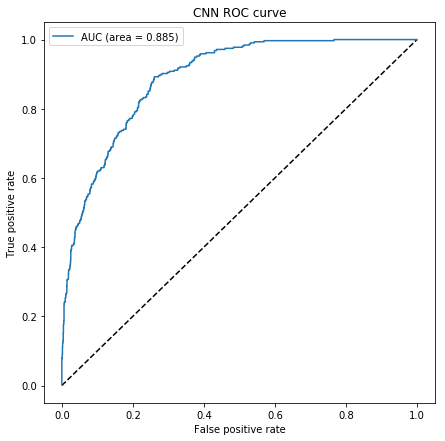

Wall time: 34min 46s


In [26]:
%%time

# same batch size and epochs

model2 = createModel2(input_shape,num_classes)

datagen = ImageDataGenerator(
    zoom_range=0.2,          # randomly zoom into images
    rotation_range=90,      # randomly rotate images in the range (degrees, 0 to 180). 
    width_shift_range=0.1,   # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,    # randomly flip images
    vertical_flip=True)      # randomly flip images


# set up model checkpoint
#save_dir = r'C:\Users\Admin\OneDrive - mycit.ie\Documents\CIT\Semester 2\Final Project\Latest Models\Saved_Mods'
save_path = 'Best_AUC.hdf5'

# save highest AUC out of all epochs (can also monitor recall,precision and f-score)
checkpoint = ModelCheckpoint(save_path, monitor='val_auroc', verbose=1, save_best_only=True, mode='max')

# reduce learning rate if AUC stagnates
reduce_lr = ReduceLROnPlateau(monitor='val_auroc', factor=0.2,patience=5, min_lr=0.0001)

# Fit the model on the images
history2 = model2.fit_generator(datagen.flow(xtrain, ytrain, batch_size=batch_size),
                                steps_per_epoch=int(np.ceil(xtrain.shape[0] / float(batch_size))),
                                epochs=epochs,
                                class_weight={0: 1, 1: 4},
                                validation_data=(xtest, ytest),
                                callbacks=[checkpoint,reduce_lr],
                                workers=7)

Audio(sound_file, autoplay=True)

2102/2102 [==============================] - 4s 2ms/step

Validation loss: 0.3532825264898966
Validation auc: 0.8847374933086313
Validation precision: 0.41824440612422636
Validation recall: 0.7689873415288015
Validation F Score: 0.5418059743100103 

              precision    recall  f1-score   support

Non Melanoma       0.95      0.81      0.88      1786
    Melanoma       0.42      0.77      0.54       316

 avg / total       0.87      0.80      0.83      2102

Confusion matrix


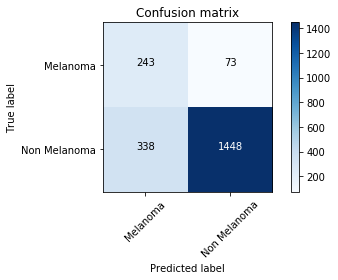

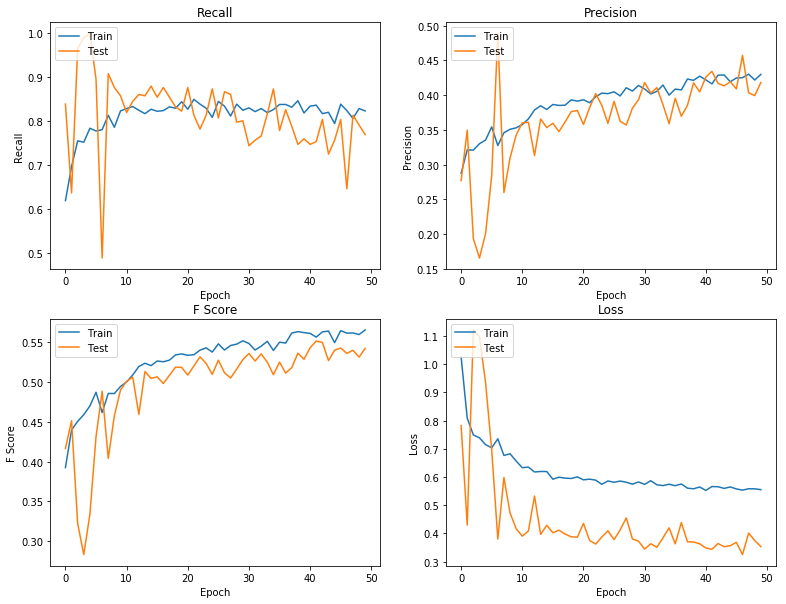

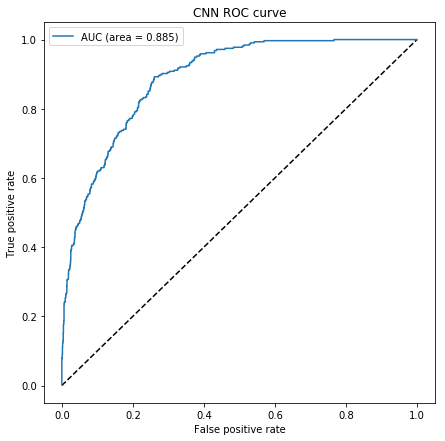

In [27]:
# reload best model - initialize model again
model2 = createModel2(input_shape,num_classes)

#load weights
model2.load_weights('Best_AUC.hdf5')
get_stats(model2,history2,xtest,ytest)

Remove another set, increase filters to 64, remove droput, increase dense. Had to reduce to 32 again - OOM. Current models using about 80% of GPU memory (4GB). Try 64 feature detectors on lab computers. 

In [32]:
def createModel3(input_shape,num_classes):

    
    model = Sequential()

    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Flatten())
    
    model.add(Dense(512, activation='relu'))

    model.add(Dense(256, activation='relu'))
    
    model.add(Dense(num_classes, activation='sigmoid'))
    
    #adam = Adam(lr=0.0001)
    #adam = Adam(lr=1e-3, decay=1e-3 / 200)
    
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=[auroc,km.binary_precision(), km.binary_recall(),km.binary_f1_score()])
    
    return model

In [33]:
%%time

# same batch size and epochs

model3 = createModel3(input_shape,num_classes)

datagen = ImageDataGenerator(
    zoom_range=0.2,          # randomly zoom into images
    rotation_range=90,      # randomly rotate images in the range (degrees, 0 to 180). 
    width_shift_range=0.1,   # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,    # randomly flip images
    vertical_flip=True)      # randomly flip images


# set up model checkpoint
#save_dir = r'C:\Users\Admin\OneDrive - mycit.ie\Documents\CIT\Semester 2\Final Project\Latest Models\Saved_Mods'
save_path = 'Best_AUC.hdf5'

# save highest AUC out of all epochs (can also monitor recall,precision and f-score)
checkpoint = ModelCheckpoint(save_path, monitor='val_auroc', verbose=1, save_best_only=True, mode='max')

# reduce learning rate if AUC stagnates
reduce_lr = ReduceLROnPlateau(monitor='val_auroc', factor=0.2,patience=5, min_lr=0.0001)

# Fit the model on the images
history3 = model3.fit_generator(datagen.flow(xtrain, ytrain, batch_size=batch_size),
                                steps_per_epoch=int(np.ceil(xtrain.shape[0] / float(batch_size))),
                                epochs=epochs,
                                class_weight={0: 1, 1: 4},
                                validation_data=(xtest, ytest),
                                callbacks=[checkpoint,reduce_lr],
                                workers=7)

Audio(sound_file, autoplay=True)

Epoch 1/50
66/66 [==============================] - 36s 549ms/step - loss: 1.3607 - auroc: 0.7864 - precision: 0.3037 - recall: 0.6431 - f1_score: 0.4125 - val_loss: 1.7487 - val_auroc: 0.5600 - val_precision: 0.1672 - val_recall: 0.8228 - val_f1_score: 0.2779

Epoch 00001: val_auroc improved from -inf to 0.55998, saving model to Best_AUC.hdf5
Epoch 2/50
66/66 [==============================] - 42s 641ms/step - loss: 0.9344 - auroc: 0.8160 - precision: 0.3294 - recall: 0.6943 - f1_score: 0.4468 - val_loss: 0.6968 - val_auroc: 0.7847 - val_precision: 0.2959 - val_recall: 0.7848 - val_f1_score: 0.4298

Epoch 00002: val_auroc improved from 0.55998 to 0.78471, saving model to Best_AUC.hdf5
Epoch 3/50
66/66 [==============================] - 37s 561ms/step - loss: 0.8062 - auroc: 0.8359 - precision: 0.3481 - recall: 0.7176 - f1_score: 0.4688 - val_loss: 0.6764 - val_auroc: 0.8016 - val_precision: 0.3235 - val_recall: 0.6930 - val_f1_score: 0.4411

Epoch 00003: val_auroc improved from 0.7847


Epoch 00025: val_auroc did not improve from 0.88409
Epoch 26/50
66/66 [==============================] - 41s 614ms/step - loss: 0.5126 - auroc: 0.9171 - precision: 0.4584 - recall: 0.8084 - f1_score: 0.5851 - val_loss: 0.4250 - val_auroc: 0.8816 - val_precision: 0.3788 - val_recall: 0.8354 - val_f1_score: 0.5212

Epoch 00026: val_auroc did not improve from 0.88409
Epoch 27/50
66/66 [==============================] - 41s 616ms/step - loss: 0.4984 - auroc: 0.9223 - precision: 0.4792 - recall: 0.8146 - f1_score: 0.6034 - val_loss: 0.3614 - val_auroc: 0.8871 - val_precision: 0.4215 - val_recall: 0.7563 - val_f1_score: 0.5413

Epoch 00027: val_auroc improved from 0.88409 to 0.88707, saving model to Best_AUC.hdf5
Epoch 28/50
66/66 [==============================] - 40s 605ms/step - loss: 0.4921 - auroc: 0.9239 - precision: 0.4830 - recall: 0.8177 - f1_score: 0.6073 - val_loss: 0.3530 - val_auroc: 0.8855 - val_precision: 0.4346 - val_recall: 0.7468 - val_f1_score: 0.5495

Epoch 00028: val_au

2102/2102 [==============================] - 4s 2ms/step

Validation loss: 0.381141502612211
Validation auc: 0.89274911543896
Validation precision: 0.42881072019617905
Validation recall: 0.8101265820221117
Validation F Score: 0.5607885635948591 

              precision    recall  f1-score   support

Non Melanoma       0.96      0.81      0.88      1786
    Melanoma       0.43      0.81      0.56       316

 avg / total       0.88      0.81      0.83      2102

Confusion matrix


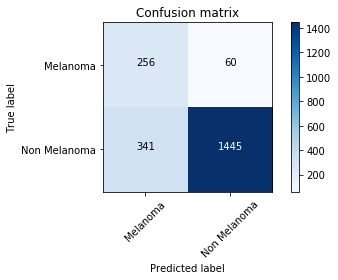

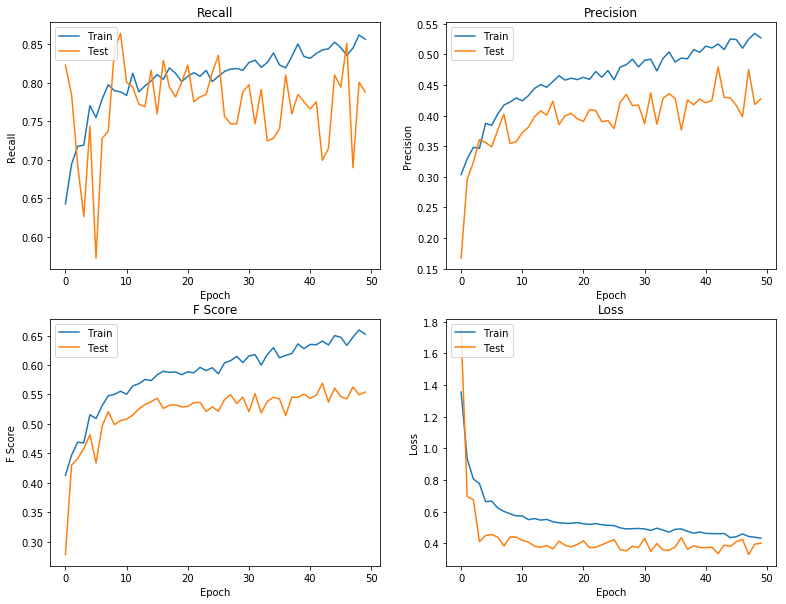

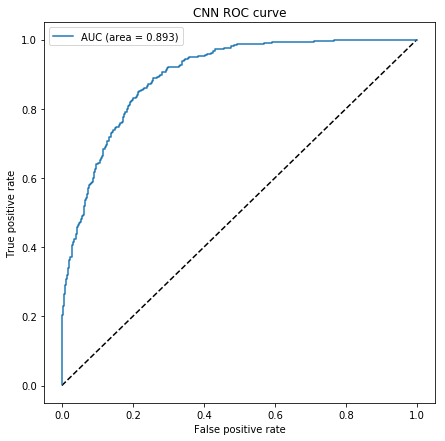

In [34]:
# reload best model - initialize model again
model3 = createModel3(input_shape,num_classes)

#load weights
model3.load_weights('Best_AUC.hdf5')
get_stats(model3,history3,xtest,ytest)

Try larger kernel size 5x5

In [40]:
def createModel4(input_shape,num_classes):

    
    model = Sequential()

    model.add(Conv2D(32, kernel_size=(5, 5), activation='relu', input_shape=input_shape))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    
    model.add(Conv2D(32, kernel_size=(5, 5), activation='relu', input_shape=input_shape))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    
    model.add(Conv2D(32, kernel_size=(5, 5), activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    
    model.add(Conv2D(32, kernel_size=(5, 5), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Flatten())
    
    model.add(Dense(512, activation='relu'))

    model.add(Dense(256, activation='relu'))
    
    model.add(Dense(num_classes, activation='sigmoid'))
    
    #adam = Adam(lr=0.0001)
    #adam = Adam(lr=1e-3, decay=1e-3 / 200)
    
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=[auroc,km.binary_precision(), km.binary_recall(),km.binary_f1_score()])
    
    return model

In [41]:
%%time

# same batch size and epochs

model4 = createModel4(input_shape,num_classes)

datagen = ImageDataGenerator(
    zoom_range=0.2,          # randomly zoom into images
    rotation_range=90,      # randomly rotate images in the range (degrees, 0 to 180). 
    width_shift_range=0.1,   # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,    # randomly flip images
    vertical_flip=True)      # randomly flip images


# set up model checkpoint
#save_dir = r'C:\Users\Admin\OneDrive - mycit.ie\Documents\CIT\Semester 2\Final Project\Latest Models\Saved_Mods'
save_path = 'Best_AUC4.hdf5'

# save highest AUC out of all epochs (can also monitor recall,precision and f-score)
checkpoint = ModelCheckpoint(save_path, monitor='val_auroc', verbose=1, save_best_only=True, mode='max')

# reduce learning rate if AUC stagnates
reduce_lr = ReduceLROnPlateau(monitor='val_auroc', factor=0.2,patience=5, min_lr=0.0001)

# Fit the model on the images
history4 = model4.fit_generator(datagen.flow(xtrain, ytrain, batch_size=batch_size),
                                steps_per_epoch=int(np.ceil(xtrain.shape[0] / float(batch_size))),
                                epochs=100,
                                class_weight={0: 1.0, 1: 4.0},
                                validation_data=(xtest, ytest),
                                callbacks=[checkpoint,reduce_lr],
                                workers=4)

Audio(sound_file, autoplay=True)

Epoch 1/100
66/66 [==============================] - 47s 707ms/step - loss: 1.3375 - auroc: 0.7568 - precision: 0.2831 - recall: 0.6268 - f1_score: 0.3901 - val_loss: 2.4642 - val_auroc: 0.7145 - val_precision: 0.1635 - val_recall: 0.9304 - val_f1_score: 0.2781

Epoch 00001: val_auroc improved from -inf to 0.71453, saving model to Best_AUC4.hdf5
Epoch 2/100
66/66 [==============================] - 46s 700ms/step - loss: 0.8934 - auroc: 0.8106 - precision: 0.3306 - recall: 0.6858 - f1_score: 0.4461 - val_loss: 0.5010 - val_auroc: 0.8225 - val_precision: 0.3621 - val_recall: 0.6772 - val_f1_score: 0.4719

Epoch 00002: val_auroc improved from 0.71453 to 0.82246, saving model to Best_AUC4.hdf5
Epoch 3/100
66/66 [==============================] - 47s 709ms/step - loss: 0.7571 - auroc: 0.8301 - precision: 0.3480 - recall: 0.7192 - f1_score: 0.4690 - val_loss: 0.8788 - val_auroc: 0.7418 - val_precision: 0.2860 - val_recall: 0.4462 - val_f1_score: 0.3486

Epoch 00003: val_auroc did not improve


Epoch 00025: val_auroc did not improve from 0.88547
Epoch 26/100
66/66 [==============================] - 48s 720ms/step - loss: 0.5057 - auroc: 0.9226 - precision: 0.4723 - recall: 0.8200 - f1_score: 0.5994 - val_loss: 0.3932 - val_auroc: 0.8550 - val_precision: 0.3858 - val_recall: 0.6361 - val_f1_score: 0.4803

Epoch 00026: val_auroc did not improve from 0.88547
Epoch 27/100
66/66 [==============================] - 47s 709ms/step - loss: 0.5157 - auroc: 0.9172 - precision: 0.4798 - recall: 0.8092 - f1_score: 0.6024 - val_loss: 0.3727 - val_auroc: 0.8799 - val_precision: 0.4371 - val_recall: 0.7373 - val_f1_score: 0.5489

Epoch 00027: val_auroc did not improve from 0.88547
Epoch 28/100
66/66 [==============================] - 47s 711ms/step - loss: 0.4991 - auroc: 0.9235 - precision: 0.4784 - recall: 0.8254 - f1_score: 0.6058 - val_loss: 0.4331 - val_auroc: 0.8762 - val_precision: 0.3957 - val_recall: 0.8228 - val_f1_score: 0.5344

Epoch 00028: val_auroc did not improve from 0.88547


Epoch 00051: val_auroc did not improve from 0.88786
Epoch 52/100
66/66 [==============================] - 47s 719ms/step - loss: 0.4290 - auroc: 0.9458 - precision: 0.5463 - recall: 0.8604 - f1_score: 0.6683 - val_loss: 0.4258 - val_auroc: 0.8755 - val_precision: 0.4048 - val_recall: 0.7468 - val_f1_score: 0.5250

Epoch 00052: val_auroc did not improve from 0.88786
Epoch 53/100
66/66 [==============================] - 48s 735ms/step - loss: 0.4386 - auroc: 0.9420 - precision: 0.5200 - recall: 0.8588 - f1_score: 0.6477 - val_loss: 0.3642 - val_auroc: 0.8799 - val_precision: 0.4240 - val_recall: 0.7152 - val_f1_score: 0.5324

Epoch 00053: val_auroc did not improve from 0.88786
Epoch 54/100
66/66 [==============================] - 48s 731ms/step - loss: 0.4332 - auroc: 0.9442 - precision: 0.5296 - recall: 0.8542 - f1_score: 0.6538 - val_loss: 0.3718 - val_auroc: 0.8693 - val_precision: 0.4325 - val_recall: 0.6487 - val_f1_score: 0.5190

Epoch 00054: val_auroc did not improve from 0.88786


Epoch 00077: val_auroc did not improve from 0.88938
Epoch 78/100
66/66 [==============================] - 47s 717ms/step - loss: 0.3615 - auroc: 0.9606 - precision: 0.5875 - recall: 0.9015 - f1_score: 0.7114 - val_loss: 0.4794 - val_auroc: 0.8656 - val_precision: 0.3864 - val_recall: 0.7532 - val_f1_score: 0.5107

Epoch 00078: val_auroc did not improve from 0.88938
Epoch 79/100
66/66 [==============================] - 49s 747ms/step - loss: 0.3624 - auroc: 0.9608 - precision: 0.5932 - recall: 0.8813 - f1_score: 0.7091 - val_loss: 0.3764 - val_auroc: 0.8844 - val_precision: 0.4480 - val_recall: 0.7089 - val_f1_score: 0.5490

Epoch 00079: val_auroc did not improve from 0.88938
Epoch 80/100
66/66 [==============================] - 48s 721ms/step - loss: 0.3650 - auroc: 0.9603 - precision: 0.5910 - recall: 0.8821 - f1_score: 0.7077 - val_loss: 0.3591 - val_auroc: 0.8862 - val_precision: 0.4784 - val_recall: 0.7342 - val_f1_score: 0.5793

Epoch 00080: val_auroc did not improve from 0.88938

KeyboardInterrupt: 

2102/2102 [==============================] - 5s 2ms/step

Validation loss: 0.3641507289559358
Validation auc: 0.8866405493498472
Validation precision: 0.46153846144742827
Validation recall: 0.7405063288795867
Validation F Score: 0.5686512283749887 

              precision    recall  f1-score   support

Non Melanoma       0.95      0.85      0.90      1786
    Melanoma       0.46      0.74      0.57       316

 avg / total       0.88      0.83      0.85      2102

Confusion matrix


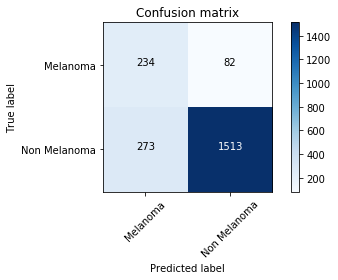

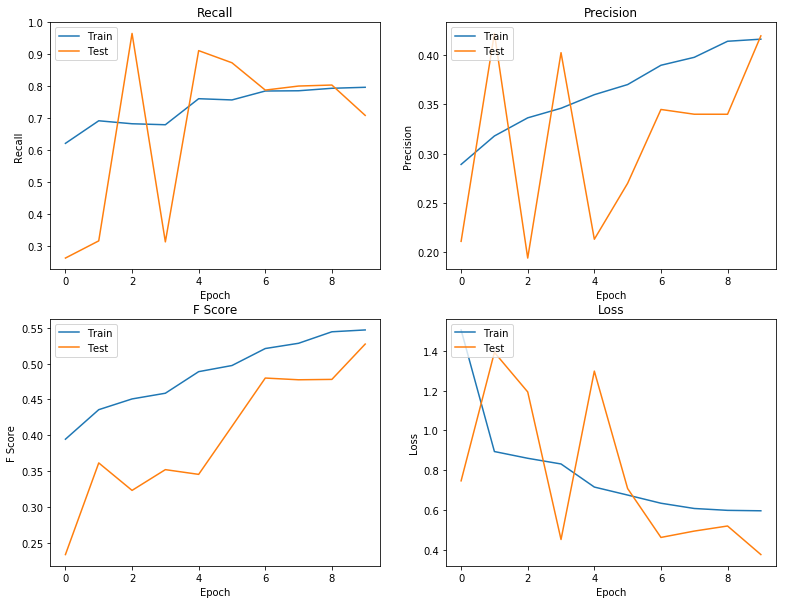

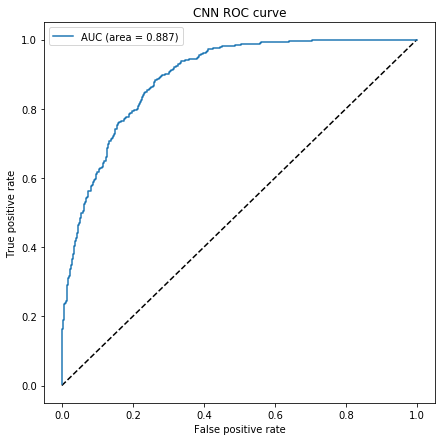

In [42]:
# reload best model - initialize model again
model4 = createModel4(input_shape,num_classes)

#load weights
model4.load_weights('Best_AUC4.hdf5')
get_stats(model4,history4,xtest,ytest)

### No learning rate annealer. Let adam optmimze.

In [12]:
def createModel5(input_shape,num_classes):

    
    model = Sequential()

    model.add(Conv2D(32, kernel_size=(5, 5), activation='relu', input_shape=input_shape))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    
    model.add(Conv2D(32, kernel_size=(5, 5), activation='relu', input_shape=input_shape))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    
    model.add(Conv2D(32, kernel_size=(5, 5), activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    
    model.add(Conv2D(32, kernel_size=(5, 5), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Flatten())
    
    model.add(Dense(512, activation='relu'))

    model.add(Dense(256, activation='relu'))
    
    model.add(Dense(num_classes, activation='sigmoid'))
    
    #adam = Adam(lr=0.0001)
    #adam = Adam(lr=1e-3, decay=1e-3 / 200)
    
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=[auroc,km.binary_precision(), km.binary_recall(),km.binary_f1_score()])
    
    return model

In [14]:
%%time

# same batch size and epochs

model5 = createModel5(input_shape,num_classes)

datagen = ImageDataGenerator(
    zoom_range=0.2,          # randomly zoom into images
    rotation_range=90,      # randomly rotate images in the range (degrees, 0 to 180). 
    width_shift_range=0.1,   # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,    # randomly flip images
    vertical_flip=True)      # randomly flip images


# set up model checkpoint
#save_dir = r'C:\Users\Admin\OneDrive - mycit.ie\Documents\CIT\Semester 2\Final Project\Latest Models\Saved_Mods'
save_path = 'Best_AUC4.hdf5'

# save highest AUC out of all epochs (can also monitor recall,precision and f-score)
checkpoint = ModelCheckpoint(save_path, monitor='val_auroc', verbose=1, save_best_only=True, mode='max')

# reduce learning rate if AUC stagnates
#reduce_lr = ReduceLROnPlateau(monitor='val_auroc', factor=0.2,patience=5, min_lr=0.0001)

# Fit the model on the images
history5 = model5.fit_generator(datagen.flow(xtrain, ytrain, batch_size=batch_size),
                                steps_per_epoch=int(np.ceil(xtrain.shape[0] / float(batch_size))),
                                epochs=50,
                                class_weight={0: 1.0, 1: 4.0},
                                validation_data=(xtest, ytest),
                                callbacks=[checkpoint],
                                workers=4)

Audio(sound_file, autoplay=True)

Epoch 1/50
66/66 [==============================] - 48s 731ms/step - loss: 1.2503 - auroc: 0.7645 - precision: 0.2906 - recall: 0.6438 - f1_score: 0.4005 - val_loss: 2.5604 - val_auroc: 0.6859 - val_precision: 0.1716 - val_recall: 0.9873 - val_f1_score: 0.2924

Epoch 00001: val_auroc improved from -inf to 0.68592, saving model to Best_AUC4.hdf5
Epoch 2/50
66/66 [==============================] - 44s 666ms/step - loss: 0.7815 - auroc: 0.8169 - precision: 0.3308 - recall: 0.7029 - f1_score: 0.4499 - val_loss: 0.5129 - val_auroc: 0.7597 - val_precision: 0.2660 - val_recall: 0.7120 - val_f1_score: 0.3873

Epoch 00002: val_auroc improved from 0.68592 to 0.75966, saving model to Best_AUC4.hdf5
Epoch 3/50
66/66 [==============================] - 44s 672ms/step - loss: 0.7455 - auroc: 0.8306 - precision: 0.3443 - recall: 0.7277 - f1_score: 0.4675 - val_loss: 0.9563 - val_auroc: 0.7499 - val_precision: 0.1934 - val_recall: 0.9304 - val_f1_score: 0.3203

Epoch 00003: val_auroc did not improve fr

66/66 [==============================] - 46s 697ms/step - loss: 0.5495 - auroc: 0.9065 - precision: 0.4396 - recall: 0.8138 - f1_score: 0.5709 - val_loss: 0.3717 - val_auroc: 0.8633 - val_precision: 0.4232 - val_recall: 0.7152 - val_f1_score: 0.5318

Epoch 00026: val_auroc did not improve from 0.87094
Epoch 27/50
66/66 [==============================] - 49s 742ms/step - loss: 0.5623 - auroc: 0.9030 - precision: 0.4436 - recall: 0.8061 - f1_score: 0.5723 - val_loss: 0.4283 - val_auroc: 0.8412 - val_precision: 0.3460 - val_recall: 0.6899 - val_f1_score: 0.4609

Epoch 00027: val_auroc did not improve from 0.87094
Epoch 28/50
66/66 [==============================] - 46s 703ms/step - loss: 0.5556 - auroc: 0.9029 - precision: 0.4504 - recall: 0.8138 - f1_score: 0.5799 - val_loss: 0.3738 - val_auroc: 0.8634 - val_precision: 0.4226 - val_recall: 0.6392 - val_f1_score: 0.5088

Epoch 00028: val_auroc did not improve from 0.87094
Epoch 29/50
66/66 [==============================] - 46s 694ms/step

2102/2102 [==============================] - 5s 2ms/step

Validation loss: 0.5275957240704465
Validation auc: 0.8867622390391158
Validation precision: 0.35301353009188025
Validation recall: 0.9082278478138519
Validation F Score: 0.5084144857286123 

              precision    recall  f1-score   support

Non Melanoma       0.98      0.71      0.82      1786
    Melanoma       0.35      0.91      0.51       316

 avg / total       0.88      0.74      0.77      2102

Confusion matrix


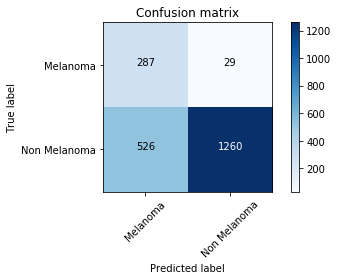

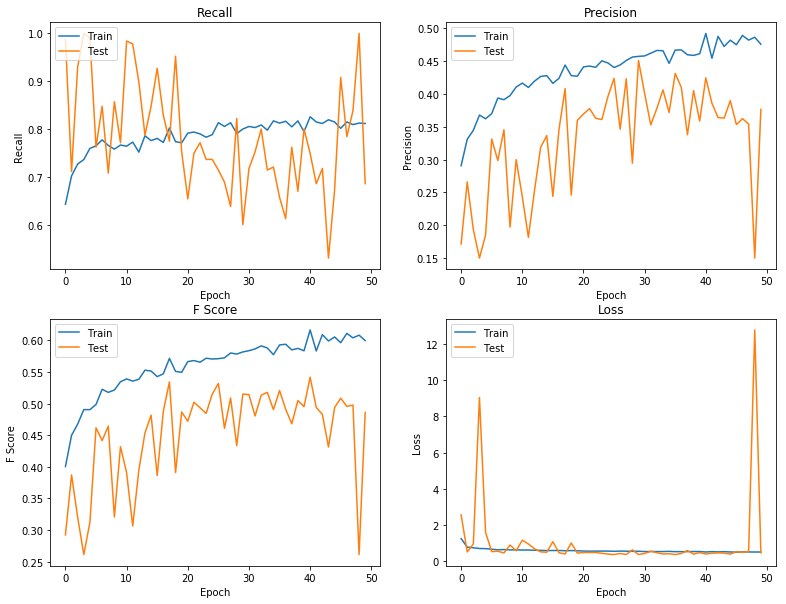

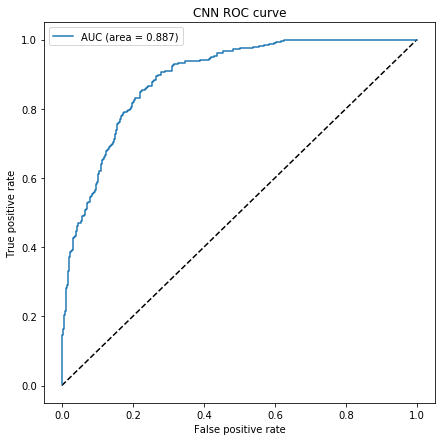

In [15]:
# reload best model - initialize model again
model5 = createModel5(input_shape,num_classes)

#load weights
model5.load_weights('Best_AUC4.hdf5')
get_stats(model5,history5,xtest,ytest)

### Downasmpling Majority Class to 50% of original size

In [17]:
def downsamp_maj(df,target):


    df_minority = df[df[target]=='1']
    df_majority = df[df[target]=='0']

    len_majority = len(df[df[target]=='0'])

    df_majority_downsampled = resample(df_majority, 
                             replace=False,    # sample without replacement
                             n_samples = int(len_majority/2),     # remove 50% of non melanoma obs
                             random_state=123) # reproducible results 

    # Combine minority class with downsampled majority class
    df = pd.concat([df_majority_downsampled, df_minority],ignore_index=True)

    return df

In [23]:
target='class'
df_d = downsamp_maj(df,target)
df_d['class'].value_counts()

0    4451
1    1605
Name: class, dtype: int64

In [24]:
batch_size = 128
epochs = 50
num_classes = 1
input_shape = input_dims + (3,)
class_weights={0: 1, 1: 4}  

xtrain, xtest, ytrain, ytest = train_test(df_d)

# dataframe no longer needed
del df,df_d

Training set balance:
 0    3572
1    1272
Name: class, dtype: int64
Test set balance:
 0    879
1    333
Name: class, dtype: int64


Normalization - divide by 255.0 

In [25]:
xtrain,xtest = norm_255(xtrain,xtest)

In [26]:
def createModel(input_shape,num_classes):

    
    model = Sequential()

    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Flatten())
    
    model.add(Dense(512, activation='relu'))

    model.add(Dense(256, activation='relu'))
    
    model.add(Dense(num_classes, activation='sigmoid'))
    
    #adam = Adam(lr=0.0001)
    #adam = Adam(lr=1e-3, decay=1e-3 / 200)
    
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=[auroc,km.binary_precision(), km.binary_recall(),km.binary_f1_score()])
    
    return model

In [28]:
%%time

# same batch size and epochs

model3 = createModel(input_shape,num_classes)

datagen = ImageDataGenerator(
    zoom_range=0.2,          # randomly zoom into images
    rotation_range=90,      # randomly rotate images in the range (degrees, 0 to 180). 
    width_shift_range=0.1,   # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,    # randomly flip images
    vertical_flip=True)      # randomly flip images


# set up model checkpoint
#save_dir = r'C:\Users\Admin\OneDrive - mycit.ie\Documents\CIT\Semester 2\Final Project\Latest Models\Saved_Mods'
save_path = 'Best_AUC_ds.hdf5'

# save highest AUC out of all epochs (can also monitor recall,precision and f-score)
checkpoint = ModelCheckpoint(save_path, monitor='val_auroc', verbose=1, save_best_only=True, mode='max')

# reduce learning rate if AUC stagnates
reduce_lr = ReduceLROnPlateau(monitor='val_auroc', factor=0.2,patience=5, min_lr=0.0001)

# Fit the model on the images
history3 = model3.fit_generator(datagen.flow(xtrain, ytrain, batch_size=batch_size),
                                steps_per_epoch=int(np.ceil(xtrain.shape[0] / float(batch_size))),
                                epochs=epochs,
                                class_weight={0: 1, 1: 4},
                                validation_data=(xtest, ytest),
                                callbacks=[checkpoint,reduce_lr],
                                workers=7)

Audio(sound_file, autoplay=True)

Epoch 1/50
38/38 [==============================] - 28s 746ms/step - loss: 2.3976 - auroc: 0.7479 - precision: 0.4008 - recall: 0.7577 - f1_score: 0.5243 - val_loss: 1.5118 - val_auroc: 0.7402 - val_precision: 0.4452 - val_recall: 0.6216 - val_f1_score: 0.5188

Epoch 00001: val_auroc improved from -inf to 0.74025, saving model to Best_AUC_ds.hdf5
Epoch 2/50
38/38 [==============================] - 21s 553ms/step - loss: 1.2453 - auroc: 0.7821 - precision: 0.4258 - recall: 0.7987 - f1_score: 0.5555 - val_loss: 0.7667 - val_auroc: 0.7602 - val_precision: 0.4368 - val_recall: 0.6847 - val_f1_score: 0.5333

Epoch 00002: val_auroc improved from 0.74025 to 0.76015, saving model to Best_AUC_ds.hdf5
Epoch 3/50
38/38 [==============================] - 21s 547ms/step - loss: 1.0161 - auroc: 0.8205 - precision: 0.4583 - recall: 0.8459 - f1_score: 0.5945 - val_loss: 0.5459 - val_auroc: 0.7745 - val_precision: 0.4762 - val_recall: 0.6907 - val_f1_score: 0.5637

Epoch 00003: val_auroc improved from 

38/38 [==============================] - 22s 580ms/step - loss: 0.5746 - auroc: 0.9275 - precision: 0.5793 - recall: 0.9308 - f1_score: 0.7141 - val_loss: 0.4789 - val_auroc: 0.8910 - val_precision: 0.5166 - val_recall: 0.8859 - val_f1_score: 0.6527

Epoch 00026: val_auroc did not improve from 0.89394
Epoch 27/50
38/38 [==============================] - 21s 548ms/step - loss: 0.5717 - auroc: 0.9291 - precision: 0.5683 - recall: 0.9253 - f1_score: 0.7042 - val_loss: 0.4854 - val_auroc: 0.8939 - val_precision: 0.5263 - val_recall: 0.9009 - val_f1_score: 0.6645

Epoch 00027: val_auroc did not improve from 0.89394
Epoch 28/50
38/38 [==============================] - 21s 546ms/step - loss: 0.5681 - auroc: 0.9289 - precision: 0.5748 - recall: 0.9308 - f1_score: 0.7107 - val_loss: 0.4524 - val_auroc: 0.8858 - val_precision: 0.5318 - val_recall: 0.8529 - val_f1_score: 0.6551

Epoch 00028: val_auroc did not improve from 0.89394
Epoch 29/50
38/38 [==============================] - 21s 561ms/step

1212/1212 [==============================] - 3s 2ms/step

Validation loss: 0.4883648142366126
Validation auc: 0.8993839032703942
Validation precision: 0.5253940454421375
Validation recall: 0.90090090063036
Validation F Score: 0.663716767478124 

              precision    recall  f1-score   support

Non Melanoma       0.95      0.69      0.80       879
    Melanoma       0.53      0.90      0.66       333

 avg / total       0.83      0.75      0.76      1212

Confusion matrix


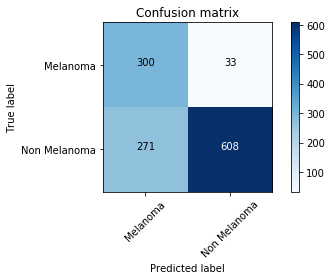

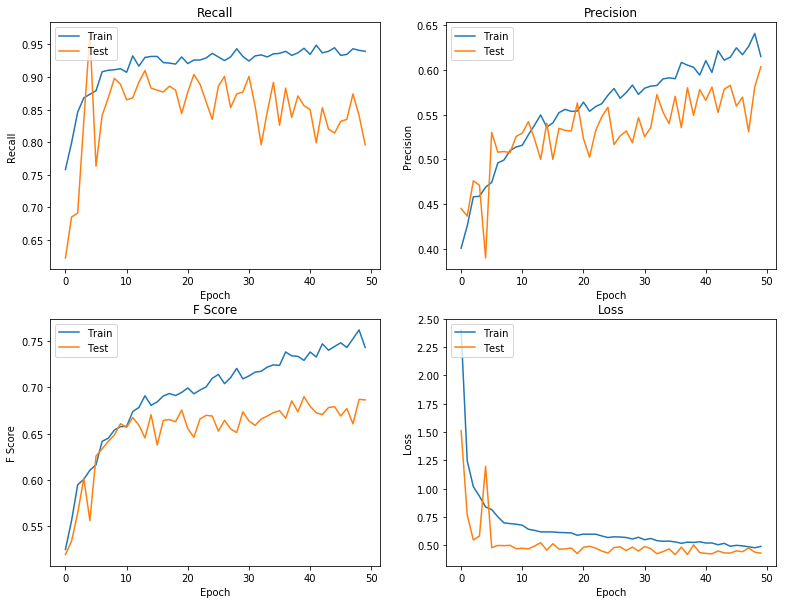

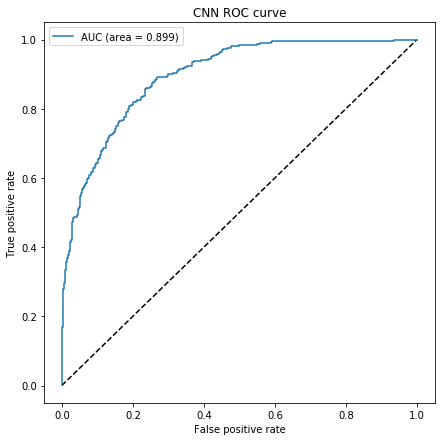

In [30]:
# reload best model - initialize model again
model3 = createModel(input_shape,num_classes)

#load weights
model3.load_weights('Best_AUC_ds.hdf5')
get_stats(model3,history3,xtest,ytest)

### Same model, now with sklearn recommended weights. Increase epochs to 100.

In [36]:
new_weights = compute_class_weight('balanced', np.unique(ytrain), ytrain)
new_weights

array([0.68, 1.9 ])

In [37]:
%%time

# same batch size and epochs

model3 = createModel(input_shape,num_classes)

datagen = ImageDataGenerator(
    zoom_range=0.2,          # randomly zoom into images
    rotation_range=90,      # randomly rotate images in the range (degrees, 0 to 180). 
    width_shift_range=0.1,   # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,    # randomly flip images
    vertical_flip=True)      # randomly flip images


# set up model checkpoint
#save_dir = r'C:\Users\Admin\OneDrive - mycit.ie\Documents\CIT\Semester 2\Final Project\Latest Models\Saved_Mods'
save_path = 'Best_AUC_ds.hdf5'

# save highest AUC out of all epochs (can also monitor recall,precision and f-score)
checkpoint = ModelCheckpoint(save_path, monitor='val_auroc', verbose=1, save_best_only=True, mode='max')

# reduce learning rate if AUC stagnates
reduce_lr = ReduceLROnPlateau(monitor='val_auroc', factor=0.2,patience=5, min_lr=0.0001)

# Fit the model on the images
history3 = model3.fit_generator(datagen.flow(xtrain, ytrain, batch_size=batch_size),
                                steps_per_epoch=int(np.ceil(xtrain.shape[0] / float(batch_size))),
                                epochs=100,
                                class_weight={0: 0.68, 1: 1.9},
                                validation_data=(xtest, ytest),
                                callbacks=[checkpoint,reduce_lr],
                                workers=7)

Audio(sound_file, autoplay=True)

Epoch 1/100
38/38 [==============================] - 22s 578ms/step - loss: 1.6902 - auroc: 0.7283 - precision: 0.4001 - recall: 0.6876 - f1_score: 0.5059 - val_loss: 4.7750 - val_auroc: 0.6963 - val_precision: 0.3271 - val_recall: 0.9970 - val_f1_score: 0.4926

Epoch 00001: val_auroc improved from -inf to 0.69630, saving model to Best_AUC_ds.hdf5
Epoch 2/100
38/38 [==============================] - 21s 553ms/step - loss: 0.7257 - auroc: 0.7976 - precision: 0.4640 - recall: 0.7602 - f1_score: 0.5763 - val_loss: 1.5071 - val_auroc: 0.6758 - val_precision: 0.3256 - val_recall: 0.9279 - val_f1_score: 0.4821

Epoch 00002: val_auroc did not improve from 0.69630
Epoch 3/100
38/38 [==============================] - 21s 558ms/step - loss: 0.6035 - auroc: 0.8212 - precision: 0.4763 - recall: 0.7901 - f1_score: 0.5943 - val_loss: 0.7091 - val_auroc: 0.8006 - val_precision: 0.4894 - val_recall: 0.7658 - val_f1_score: 0.5972

Epoch 00003: val_auroc improved from 0.69630 to 0.80059, saving model to

38/38 [==============================] - 29s 766ms/step - loss: 0.2773 - auroc: 0.9507 - precision: 0.6705 - recall: 0.9198 - f1_score: 0.7756 - val_loss: 0.4149 - val_auroc: 0.8951 - val_precision: 0.6128 - val_recall: 0.8078 - val_f1_score: 0.6969

Epoch 00051: val_auroc did not improve from 0.90106
Epoch 52/100
38/38 [==============================] - 22s 582ms/step - loss: 0.2747 - auroc: 0.9526 - precision: 0.6810 - recall: 0.9214 - f1_score: 0.7832 - val_loss: 0.4448 - val_auroc: 0.8803 - val_precision: 0.5903 - val_recall: 0.7658 - val_f1_score: 0.6667

Epoch 00052: val_auroc did not improve from 0.90106
Epoch 53/100
38/38 [==============================] - 24s 627ms/step - loss: 0.2814 - auroc: 0.9494 - precision: 0.6696 - recall: 0.8986 - f1_score: 0.7674 - val_loss: 0.4201 - val_auroc: 0.8922 - val_precision: 0.6348 - val_recall: 0.7988 - val_f1_score: 0.7074

Epoch 00053: val_auroc did not improve from 0.90106
Epoch 54/100
38/38 [==============================] - 22s 569ms/s

38/38 [==============================] - 22s 585ms/step - loss: 0.2419 - auroc: 0.9625 - precision: 0.7194 - recall: 0.9230 - f1_score: 0.8085 - val_loss: 0.4481 - val_auroc: 0.8853 - val_precision: 0.6117 - val_recall: 0.7568 - val_f1_score: 0.6765

Epoch 00077: val_auroc did not improve from 0.90230
Epoch 78/100
38/38 [==============================] - 22s 568ms/step - loss: 0.2246 - auroc: 0.9683 - precision: 0.7165 - recall: 0.9300 - f1_score: 0.8094 - val_loss: 0.4030 - val_auroc: 0.8981 - val_precision: 0.6614 - val_recall: 0.7568 - val_f1_score: 0.7059

Epoch 00078: val_auroc did not improve from 0.90230
Epoch 79/100
38/38 [==============================] - 22s 566ms/step - loss: 0.2313 - auroc: 0.9664 - precision: 0.7241 - recall: 0.9222 - f1_score: 0.8112 - val_loss: 0.4023 - val_auroc: 0.9041 - val_precision: 0.6270 - val_recall: 0.8078 - val_f1_score: 0.7060

Epoch 00079: val_auroc improved from 0.90230 to 0.90405, saving model to Best_AUC_ds.hdf5
Epoch 80/100
38/38 [=======

1212/1212 [==============================] - 2s 2ms/step

Validation loss: 0.4111753264472823
Validation auc: 0.9115808978989332
Validation precision: 0.6515513124936633
Validation recall: 0.8198198195736276
Validation F Score: 0.7260637802480654 

              precision    recall  f1-score   support

Non Melanoma       0.92      0.83      0.88       879
    Melanoma       0.65      0.82      0.73       333

 avg / total       0.85      0.83      0.84      1212

Confusion matrix


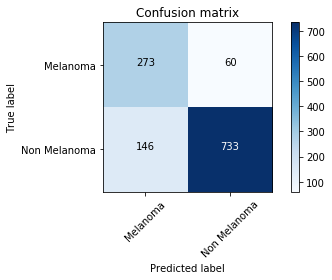

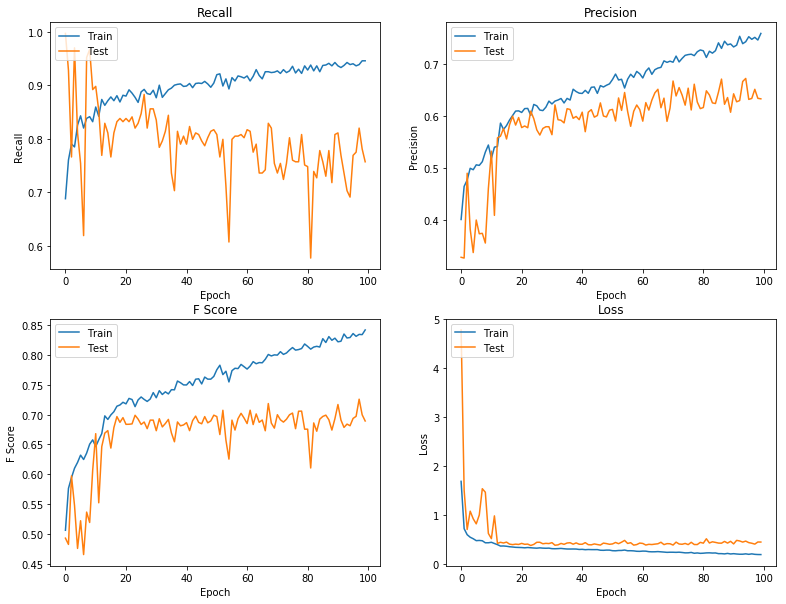

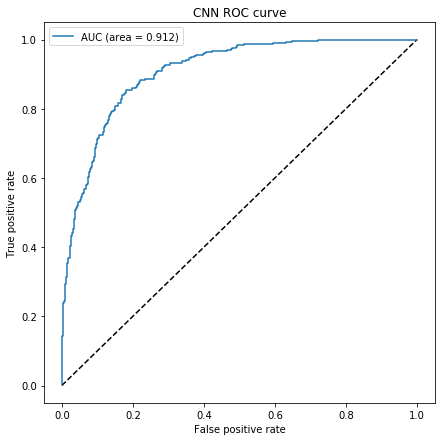

In [38]:
# reload best model - initialize model again
model3 = createModel(input_shape,num_classes)

#load weights
model3.load_weights('Best_AUC_ds.hdf5')
get_stats(model3,history3,xtest,ytest)

### Naive Oversampling: Upsample with replacement of Melanoma Class

The images will be balanced after upsampling, therefore the F1 score will now be a useful metric to track. 

In [17]:
def upsamp_min(df,target):


    df_minority = df[df[target]=='1']
    df_majority = df[df[target]=='0']

    len_majority = len(df[df[target]=='0'])

    df_minority_upsampled = resample(df_minority, 
                             replace=True,    # sample with replacement
                             n_samples = int(len_majority),     # resample to len of majority class
                             random_state=123) # reproducible results 

    # Combine minority class with downsampled majority class
    df = pd.concat([df_minority_upsampled, df_majority],ignore_index=True)

    return df

In [18]:
target='class'
df_d = upsamp_min(df,target)
df_d['class'].value_counts()

1    8902
0    8902
Name: class, dtype: int64

In [22]:
batch_size = 128
epochs = 50
num_classes = 1
input_shape = input_dims + (3,)
#class_weights={0: 1, 1: 4} class weight adjustment not needed now due to resampling

xtrain, xtest, ytrain, ytest = train_test(df_d)

# dataframe no longer needed
del df,df_d

Training set balance:
 1    7169
0    7074
Name: class, dtype: int64
Test set balance:
 0    1828
1    1733
Name: class, dtype: int64


In [23]:
xtrain,xtest = norm_255(xtrain,xtest)

In [20]:
def createModel(input_shape,num_classes):

    
    model = Sequential()

    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Flatten())
    
    model.add(Dense(512, activation='relu'))

    model.add(Dense(256, activation='relu'))
    
    model.add(Dense(num_classes, activation='sigmoid'))
    
    #adam = Adam(lr=0.0001)
    #adam = Adam(lr=1e-3, decay=1e-3 / 200)
    
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=[auroc,km.binary_precision(), km.binary_recall(),km.binary_f1_score()])
    
    return model

In [25]:
%%time

# same batch size and epochs

model3 = createModel(input_shape,num_classes)

datagen = ImageDataGenerator(
    zoom_range=0.2,          # randomly zoom into images
    rotation_range=90,      # randomly rotate images in the range (degrees, 0 to 180). 
    width_shift_range=0.1,   # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,    # randomly flip images
    vertical_flip=True)      # randomly flip images


# set up model checkpoint
#save_dir = r'C:\Users\Admin\OneDrive - mycit.ie\Documents\CIT\Semester 2\Final Project\Latest Models\Saved_Mods'
save_path = 'Best_AUC_UPS.hdf5'

# save highest AUC out of all epochs (can also monitor recall,precision and f-score)
checkpoint = ModelCheckpoint(save_path, monitor='val_auroc', verbose=1, save_best_only=True, mode='max')

# reduce learning rate if AUC stagnates
reduce_lr = ReduceLROnPlateau(monitor='val_auroc', factor=0.2,patience=5, min_lr=0.0001)

# Fit the model on the images. removed class weights parameter - dataset is now balanced due to upsampling
history3 = model3.fit_generator(datagen.flow(xtrain, ytrain, batch_size=batch_size),
                                steps_per_epoch=int(np.ceil(xtrain.shape[0] / float(batch_size))),
                                epochs=100,
                                validation_data=(xtest, ytest),
                                callbacks=[checkpoint,reduce_lr],
                                workers=7)

Audio(sound_file, autoplay=True)

Epoch 1/100
112/112 [==============================] - 79s 707ms/step - loss: 0.7058 - auroc: 0.8179 - precision: 0.7168 - recall: 0.7793 - f1_score: 0.7467 - val_loss: 0.5872 - val_auroc: 0.8199 - val_precision: 0.7004 - val_recall: 0.8078 - val_f1_score: 0.7503

Epoch 00001: val_auroc improved from -inf to 0.81991, saving model to Best_AUC_UPS.hdf5
Epoch 2/100
112/112 [==============================] - 77s 691ms/step - loss: 0.4655 - auroc: 0.8632 - precision: 0.7500 - recall: 0.8316 - f1_score: 0.7887 - val_loss: 0.7212 - val_auroc: 0.8269 - val_precision: 0.6489 - val_recall: 0.9319 - val_f1_score: 0.7650

Epoch 00002: val_auroc improved from 0.81991 to 0.82687, saving model to Best_AUC_UPS.hdf5
Epoch 3/100
112/112 [==============================] - 77s 683ms/step - loss: 0.4436 - auroc: 0.8771 - precision: 0.7599 - recall: 0.8498 - f1_score: 0.8023 - val_loss: 1.9460 - val_auroc: 0.7064 - val_precision: 0.5468 - val_recall: 0.9937 - val_f1_score: 0.7054

Epoch 00003: val_auroc did

Epoch 25/100
112/112 [==============================] - 77s 686ms/step - loss: 0.2519 - auroc: 0.9590 - precision: 0.8639 - recall: 0.9268 - f1_score: 0.8942 - val_loss: 0.2839 - val_auroc: 0.9498 - val_precision: 0.8306 - val_recall: 0.9510 - val_f1_score: 0.8867

Epoch 00025: val_auroc improved from 0.94717 to 0.94978, saving model to Best_AUC_UPS.hdf5
Epoch 26/100
112/112 [==============================] - 78s 695ms/step - loss: 0.2489 - auroc: 0.9602 - precision: 0.8701 - recall: 0.9280 - f1_score: 0.8981 - val_loss: 0.3213 - val_auroc: 0.9458 - val_precision: 0.7936 - val_recall: 0.9763 - val_f1_score: 0.8755

Epoch 00026: val_auroc did not improve from 0.94978
Epoch 27/100
112/112 [==============================] - 79s 704ms/step - loss: 0.2503 - auroc: 0.9600 - precision: 0.8656 - recall: 0.9311 - f1_score: 0.8972 - val_loss: 0.2970 - val_auroc: 0.9417 - val_precision: 0.8429 - val_recall: 0.9071 - val_f1_score: 0.8738

Epoch 00027: val_auroc did not improve from 0.94978
Epoch 2


Epoch 00049: val_auroc did not improve from 0.96748
Epoch 50/100
112/112 [==============================] - 77s 690ms/step - loss: 0.1643 - auroc: 0.9827 - precision: 0.9167 - recall: 0.9575 - f1_score: 0.9366 - val_loss: 0.2272 - val_auroc: 0.9665 - val_precision: 0.8909 - val_recall: 0.9377 - val_f1_score: 0.9137

Epoch 00050: val_auroc did not improve from 0.96748
Epoch 51/100
112/112 [==============================] - 77s 692ms/step - loss: 0.1627 - auroc: 0.9835 - precision: 0.9162 - recall: 0.9598 - f1_score: 0.9375 - val_loss: 0.2188 - val_auroc: 0.9687 - val_precision: 0.8885 - val_recall: 0.9383 - val_f1_score: 0.9127

Epoch 00051: val_auroc improved from 0.96748 to 0.96866, saving model to Best_AUC_UPS.hdf5
Epoch 52/100
112/112 [==============================] - 77s 685ms/step - loss: 0.1566 - auroc: 0.9845 - precision: 0.9184 - recall: 0.9570 - f1_score: 0.9373 - val_loss: 0.2399 - val_auroc: 0.9637 - val_precision: 0.9062 - val_recall: 0.8863 - val_f1_score: 0.8961

Epoch 

112/112 [==============================] - 79s 709ms/step - loss: 0.0811 - auroc: 0.9958 - precision: 0.9625 - recall: 0.9799 - f1_score: 0.9711 - val_loss: 0.3610 - val_auroc: 0.9513 - val_precision: 0.8583 - val_recall: 0.9019 - val_f1_score: 0.8796

Epoch 00100: val_auroc did not improve from 0.97814
Wall time: 2h 9min 54s


3561/3561 [==============================] - 7s 2ms/step

Validation loss: 0.20538888708054098
Validation auc: 0.9788368038225803
Validation precision: 0.9052234786803864
Validation recall: 0.969994229603578
Validation F Score: 0.9364902007038612 

              precision    recall  f1-score   support

Non Melanoma       0.97      0.90      0.94      1828
    Melanoma       0.91      0.97      0.94      1733

 avg / total       0.94      0.94      0.94      3561

Confusion matrix


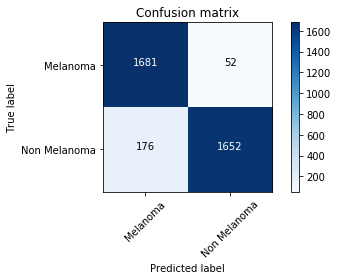

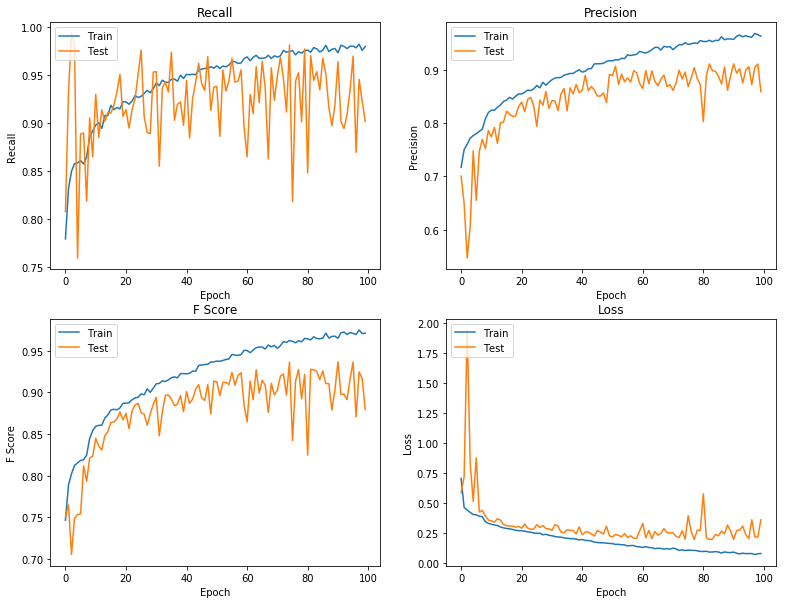

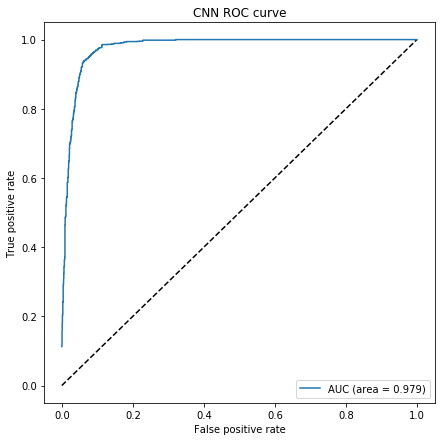

In [26]:
# reload best model - initialize model again
model3 = createModel(input_shape,num_classes)

#load weights
model3.load_weights('Best_AUC_UPS.hdf5')
get_stats(model3,history3,xtest,ytest)

### Evaluate the model above with a different threshold

Try a threshold of 0.2 ie. if there's a 20% chance or more that the leson is melanoma, classify it as melanoma. get_stats_thresh function below allows you to specify your own threshold. 

3561/3561 [==============================] - 7s 2ms/step

Validation loss: 0.20538888708054098
Validation auc: 0.9788368038225803
Validation precision: 0.9052234786803864
Validation recall: 0.969994229603578
Validation F Score: 0.9364902007038612 

              precision    recall  f1-score   support

Non Melanoma       0.99      0.85      0.92      1828
    Melanoma       0.87      0.99      0.92      1733

 avg / total       0.93      0.92      0.92      3561

Confusion matrix


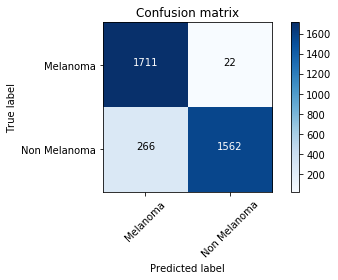

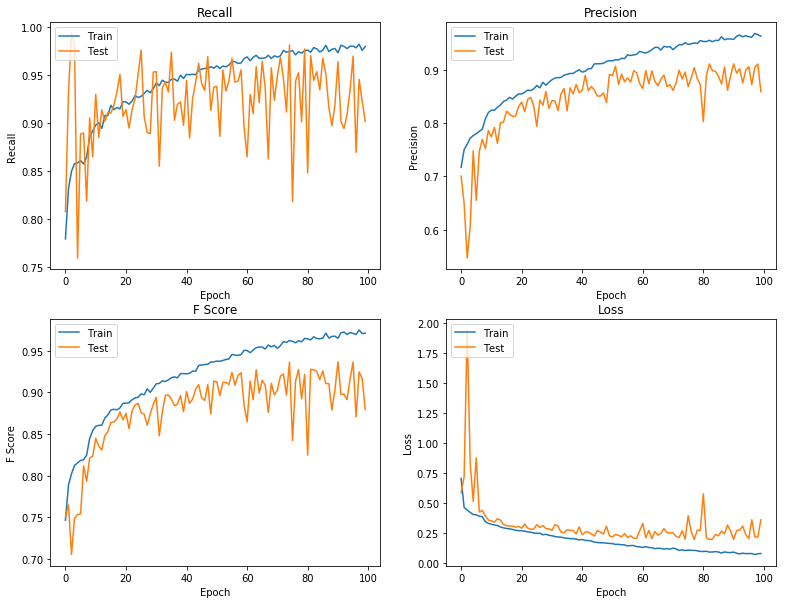

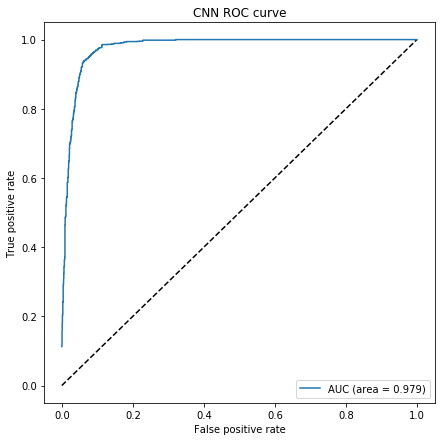

In [33]:
# reload best model - initialize model again
model3 = createModel(input_shape,num_classes)

#load weights
model3.load_weights('Best_AUC_UPS.hdf5')

get_stats_thresh(model3,history3,xtest,ytest,0.2)

### Same Model - now upsampled with SMOTE (Synthetic Minority Oversampling)

In [2]:
df=pd.read_pickle(r'C:\Users\Admin\OneDrive - mycit.ie\Documents\CIT\Semester 2\Final Project\PW Submission 1\200_200_new_ims.pkl')

In [15]:
from imblearn.over_sampling import SMOTE

# initialise the SMOTE upsampler
smote = SMOTE(ratio='minority')
print('Upsampler initialised')
# isolate images
x = df['image']
# convert to float32 array
x = np.asarray(x.tolist()).astype('float32')
print("Images converted to array")

# isolate class
y = df['class']
# convert to integer arry
y = np.asarray(y.tolist(),dtype=np.uint8)
print('Class converted to integer array')
# delete original dataframe to free up RAM
del df
print('Original dataframe deleted')
# normalise images
x = x/255.0
print('Images normalized')

Upsampler initialised
Images converted to array
Class converted to integer array
Original dataframe deleted
Images normalized


Now upsample the minority class. Needs to be reshaped to work with SMOTE. 

In [16]:
x, y = smote.fit_sample(x.reshape(x.shape[0], -1), y)

In [18]:
x = x.reshape(x.shape[0], 200, 200, 3)

In [19]:
batch_size = 128
epochs = 50
num_classes = 1
input_shape = (200,200,3)
#class_weights={0: 1, 1: 4} class weight adjustment not needed now due to resampling

xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2,random_state=5)
# dataframes no longer needed - clear from RAM
del x,y

The f1_score metric will now be tracked given that the dataset has been balanced via SMOTE upsampling. 

In [22]:
# same batch size and epochs

model3 = createModel(input_shape,num_classes)

datagen = ImageDataGenerator(
    zoom_range=0.2,          # randomly zoom into images
    rotation_range=90,      # randomly rotate images in the range (degrees, 0 to 180). 
    width_shift_range=0.1,   # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,    # randomly flip images
    vertical_flip=True)      # randomly flip images


# set up model checkpoint
#save_dir = r'C:\Users\Admin\OneDrive - mycit.ie\Documents\CIT\Semester 2\Final Project\Latest Models\Saved_Mods'
save_path = 'Best_AUC_SMOTE_UP.hdf5'

# save highest AUC out of all epochs (can also monitor recall,precision and f-score)
checkpoint = ModelCheckpoint(save_path, monitor='val_f1_score', verbose=1, save_best_only=True, mode='max')

# reduce learning rate if AUC stagnates
reduce_lr = ReduceLROnPlateau(monitor='val_f1_score', factor=0.2,patience=5, min_lr=0.0001)

# Fit the model on the images. removed class weights parameter - dataset is now balanced due to upsampling
history3 = model3.fit_generator(datagen.flow(xtrain, ytrain, batch_size=batch_size),
                                steps_per_epoch=int(np.ceil(xtrain.shape[0] / float(64))),
                                epochs=100,
                                validation_data=(xtest, ytest),
                                callbacks=[checkpoint,reduce_lr],
                                workers=7)

Epoch 1/100
223/223 [==============================] - 125s 560ms/step - loss: 0.5834 - auroc: 0.8256 - precision: 0.7256 - recall: 0.7764 - f1_score: 0.7502 - val_loss: 0.5161 - val_auroc: 0.8255 - val_precision: 0.7402 - val_recall: 0.7529 - val_f1_score: 0.7465

Epoch 00001: val_f1_score improved from -inf to 0.74649, saving model to Best_AUC_SMOTE_UP.hdf5
Epoch 2/100
223/223 [==============================] - 122s 546ms/step - loss: 0.4409 - auroc: 0.8736 - precision: 0.7576 - recall: 0.8292 - f1_score: 0.7918 - val_loss: 1.1851 - val_auroc: 0.8381 - val_precision: 0.9149 - val_recall: 0.2388 - val_f1_score: 0.3787

Epoch 00002: val_f1_score did not improve from 0.74649
Epoch 3/100
223/223 [==============================] - 127s 568ms/step - loss: 0.4125 - auroc: 0.8879 - precision: 0.7724 - recall: 0.8430 - f1_score: 0.8061 - val_loss: 1.7662 - val_auroc: 0.7671 - val_precision: 0.5704 - val_recall: 0.9989 - val_f1_score: 0.7261

Epoch 00003: val_f1_score did not improve from 0.74

223/223 [==============================] - 127s 571ms/step - loss: 0.1035 - auroc: 0.9935 - precision: 0.9517 - recall: 0.9667 - f1_score: 0.9591 - val_loss: 0.2595 - val_auroc: 0.9696 - val_precision: 0.9254 - val_recall: 0.8956 - val_f1_score: 0.9103

Epoch 00050: val_f1_score did not improve from 0.91065
Epoch 51/100
223/223 [==============================] - 127s 568ms/step - loss: 0.0994 - auroc: 0.9943 - precision: 0.9517 - recall: 0.9672 - f1_score: 0.9594 - val_loss: 0.3729 - val_auroc: 0.9592 - val_precision: 0.9216 - val_recall: 0.8090 - val_f1_score: 0.8616

Epoch 00051: val_f1_score did not improve from 0.91065
Epoch 52/100
223/223 [==============================] - 126s 565ms/step - loss: 0.1001 - auroc: 0.9941 - precision: 0.9561 - recall: 0.9666 - f1_score: 0.9613 - val_loss: 0.3723 - val_auroc: 0.9524 - val_precision: 0.9014 - val_recall: 0.8523 - val_f1_score: 0.8761

Epoch 00052: val_f1_score did not improve from 0.91065
Epoch 53/100
223/223 [=========================

223/223 [==============================] - 132s 591ms/step - loss: 0.0508 - auroc: 0.9983 - precision: 0.9815 - recall: 0.9846 - f1_score: 0.9830 - val_loss: 0.8867 - val_auroc: 0.9164 - val_precision: 0.8776 - val_recall: 0.6691 - val_f1_score: 0.7593

Epoch 00100: val_f1_score did not improve from 0.93311


Now get stats - first with default 0.5 threshold. Then reduce the threshold if false negatives are too high. 

3561/3561 [==============================] - 7s 2ms/step

Validation loss: 0.2533236018093541
Validation auc: 0.9774833714528252
Validation precision: 0.936765528766829
Validation recall: 0.9294836201593846
Validation F Score: 0.9331103178417277 

              precision    recall  f1-score   support

Non Melanoma       0.93      0.94      0.93      1760
    Melanoma       0.94      0.93      0.93      1801

   micro avg       0.93      0.93      0.93      3561
   macro avg       0.93      0.93      0.93      3561
weighted avg       0.93      0.93      0.93      3561

Confusion matrix


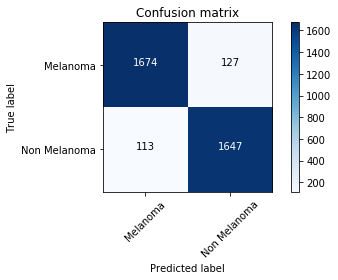

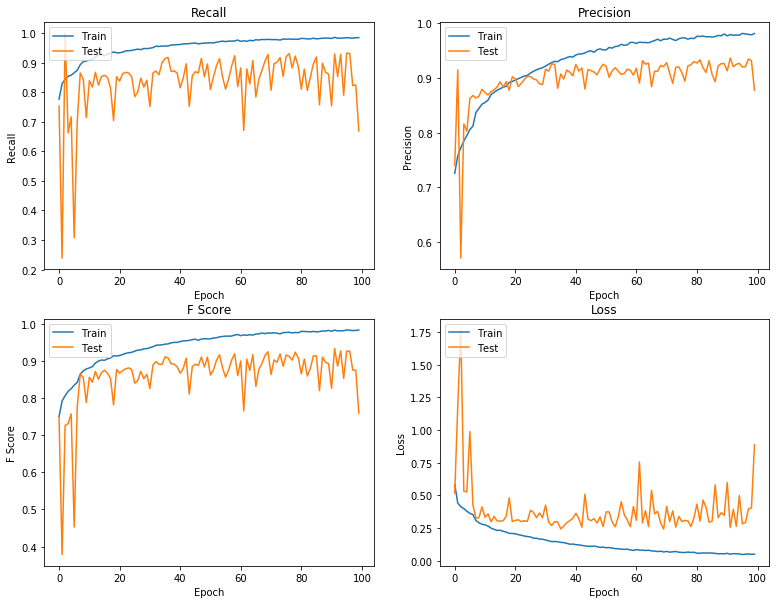

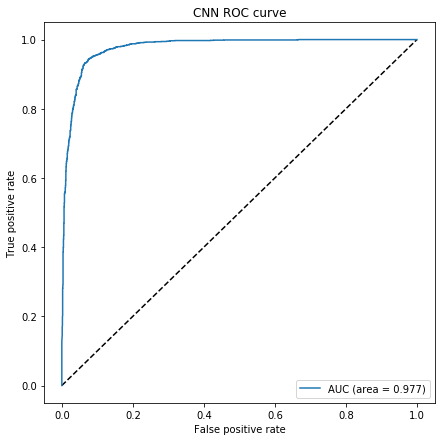

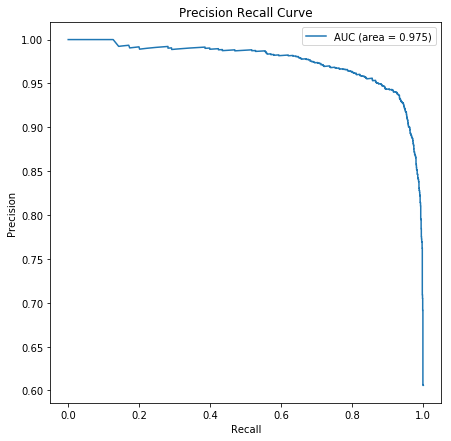

In [24]:
# reload best model - initialize model again
model3 = createModel(input_shape,num_classes)

#load weights
model3.load_weights('Best_AUC_SMOTE_UP.hdf5')

get_stats(model3,history3,xtest,ytest)

Reduce the threshold fro 0.5 to 0.1 to make it highly sensitive to anything that may resemble melanoma...

3561/3561 [==============================] - 6s 2ms/step

Validation loss: 0.2533236018093541
Validation auc: 0.9774833714528252
Validation precision: 0.936765528766829
Validation recall: 0.9294836201593846
Validation F Score: 0.9331103178417277 

              precision    recall  f1-score   support

Non Melanoma       0.96      0.88      0.92      1760
    Melanoma       0.89      0.97      0.93      1801

   micro avg       0.92      0.92      0.92      3561
   macro avg       0.93      0.92      0.92      3561
weighted avg       0.93      0.92      0.92      3561

Confusion matrix


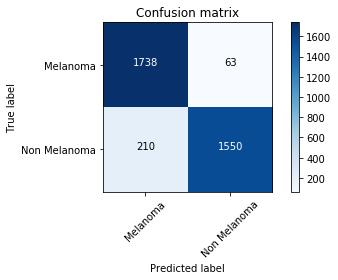

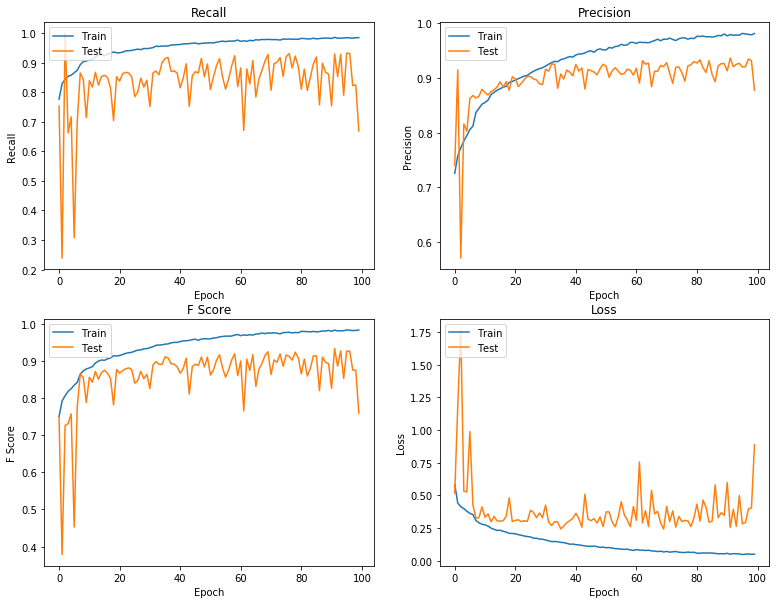

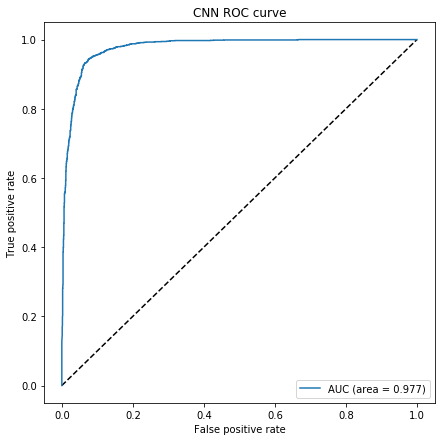

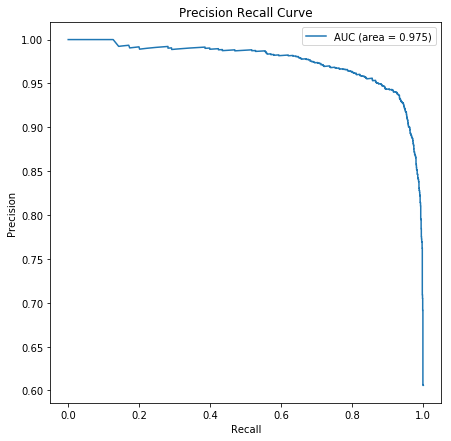

In [28]:
get_stats_thresh(model3,history3,xtest,ytest,0.1)

### Transfer Learning with VGGNet on smote upsampled images. 
vgg_model.trainable = False
for layer in vgg_model.layers:
    layer.trainable = False

In [30]:
vgg_model = applications.VGG16(include_top=False,weights='imagenet',input_shape=input_shape)
vgg_model.trainable = False 

for layer in vgg_model.layers: 
    layer.trainable = False

In [31]:
xtrain.shape

(14243, 200, 200, 3)

In [34]:
def get_bottleneck_features(model, input_imgs):
    features = model.predict(input_imgs, verbose=1)
    return features
    
train_features_vgg = get_bottleneck_features(vgg_model, xtrain)
validation_features_vgg = get_bottleneck_features(vgg_model, xtest)

print('Train Bottleneck Features:', train_features_vgg.shape, 
      '\tValidation Bottleneck Features:', validation_features_vgg.shape)

3561/3561 [==============================] - 54s 15ms/step
Train Bottleneck Features: (14243, 6, 6, 512) 	Validation Bottleneck Features: (3561, 6, 6, 512)


In [36]:
model = Sequential()
model.add(Flatten(input_shape=train_features_vgg.shape[1:]))
model.add(Dense(512,activation='relu'))
model.add(Dense(256,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=[auroc,km.binary_precision(), km.binary_recall(),km.binary_f1_score()])



In [39]:
batch_size=128

save_path = 'transf.hdf5'

# save highest F! out of all epochs (can also monitor recall,precision and f-score)
checkpoint = ModelCheckpoint(save_path, monitor='val_f1_score', verbose=1, save_best_only=True, mode='max')

# reduce learning rate if AUC stagnates
reduce_lr = ReduceLROnPlateau(monitor='val_f1_score', factor=0.2,patience=5, min_lr=0.0001)

historynew = model.fit(train_features_vgg,ytrain, batch_size=batch_size,callbacks=[reduce_lr,checkpoint],epochs=100,validation_data=(validation_features_vgg, ytest),verbose=1)



Train on 14243 samples, validate on 3561 samples
Epoch 1/100
14243/14243 [==============================] - 5s 329us/step - loss: 0.0102 - auroc: 1.0000 - precision: 0.9973 - recall: 0.9994 - f1_score: 0.9984 - val_loss: 0.4450 - val_auroc: 0.9614 - val_precision: 0.9146 - val_recall: 0.9395 - val_f1_score: 0.9269

Epoch 00001: val_f1_score improved from -inf to 0.92687, saving model to transf.hdf5
Epoch 2/100
14243/14243 [==============================] - 5s 336us/step - loss: 0.0098 - auroc: 1.0000 - precision: 0.9973 - recall: 0.9992 - f1_score: 0.9982 - val_loss: 0.4887 - val_auroc: 0.9613 - val_precision: 0.8974 - val_recall: 0.9572 - val_f1_score: 0.9264

Epoch 00002: val_f1_score did not improve from 0.92687
Epoch 3/100
14243/14243 [==============================] - 5s 334us/step - loss: 0.0096 - auroc: 1.0000 - precision: 0.9971 - recall: 0.9997 - f1_score: 0.9984 - val_loss: 0.5224 - val_auroc: 0.9599 - val_precision: 0.8827 - val_recall: 0.9656 - val_f1_score: 0.9223

Epoch 0


Epoch 00025: val_f1_score did not improve from 0.93093
Epoch 26/100
14243/14243 [==============================] - 5s 329us/step - loss: 0.0015 - auroc: 1.0000 - precision: 1.0000 - recall: 1.0000 - f1_score: 1.0000 - val_loss: 0.5286 - val_auroc: 0.9616 - val_precision: 0.9141 - val_recall: 0.9456 - val_f1_score: 0.9296

Epoch 00026: val_f1_score did not improve from 0.93093
Epoch 27/100
14243/14243 [==============================] - 5s 329us/step - loss: 0.0013 - auroc: 1.0000 - precision: 1.0000 - recall: 1.0000 - f1_score: 1.0000 - val_loss: 0.5528 - val_auroc: 0.9617 - val_precision: 0.9047 - val_recall: 0.9545 - val_f1_score: 0.9289

Epoch 00027: val_f1_score did not improve from 0.93093
Epoch 28/100
14243/14243 [==============================] - 5s 324us/step - loss: 0.0011 - auroc: 1.0000 - precision: 1.0000 - recall: 1.0000 - f1_score: 1.0000 - val_loss: 0.5590 - val_auroc: 0.9618 - val_precision: 0.9035 - val_recall: 0.9567 - val_f1_score: 0.9293

Epoch 00028: val_f1_score d


Epoch 00050: val_f1_score did not improve from 0.93115
Epoch 51/100
14243/14243 [==============================] - 5s 323us/step - loss: 3.9622e-04 - auroc: 1.0000 - precision: 1.0000 - recall: 1.0000 - f1_score: 1.0000 - val_loss: 0.6098 - val_auroc: 0.9611 - val_precision: 0.9061 - val_recall: 0.9539 - val_f1_score: 0.9294

Epoch 00051: val_f1_score did not improve from 0.93115
Epoch 52/100
14243/14243 [==============================] - 5s 320us/step - loss: 2.8147e-04 - auroc: 1.0000 - precision: 1.0000 - recall: 1.0000 - f1_score: 1.0000 - val_loss: 0.6043 - val_auroc: 0.9611 - val_precision: 0.9088 - val_recall: 0.9511 - val_f1_score: 0.9295

Epoch 00052: val_f1_score did not improve from 0.93115
Epoch 53/100
14243/14243 [==============================] - 5s 328us/step - loss: 3.0801e-04 - auroc: 1.0000 - precision: 1.0000 - recall: 1.0000 - f1_score: 1.0000 - val_loss: 0.6051 - val_auroc: 0.9611 - val_precision: 0.9080 - val_recall: 0.9539 - val_f1_score: 0.9304

Epoch 00053: va

14243/14243 [==============================] - 5s 323us/step - loss: 3.3802e-04 - auroc: 1.0000 - precision: 1.0000 - recall: 1.0000 - f1_score: 1.0000 - val_loss: 0.5816 - val_auroc: 0.9626 - val_precision: 0.9020 - val_recall: 0.9556 - val_f1_score: 0.9280

Epoch 00076: val_f1_score did not improve from 0.93115
Epoch 77/100
14243/14243 [==============================] - 5s 322us/step - loss: 3.2996e-04 - auroc: 1.0000 - precision: 1.0000 - recall: 1.0000 - f1_score: 1.0000 - val_loss: 0.5709 - val_auroc: 0.9628 - val_precision: 0.9071 - val_recall: 0.9489 - val_f1_score: 0.9275

Epoch 00077: val_f1_score did not improve from 0.93115
Epoch 78/100
14243/14243 [==============================] - 5s 327us/step - loss: 3.1036e-04 - auroc: 1.0000 - precision: 1.0000 - recall: 1.0000 - f1_score: 1.0000 - val_loss: 0.5751 - val_auroc: 0.9629 - val_precision: 0.9054 - val_recall: 0.9517 - val_f1_score: 0.9280

Epoch 00078: val_f1_score did not improve from 0.93115
Epoch 79/100
14243/14243 [===

3561/3561 [==============================] - 1s 197us/step

Validation loss: 0.6090575414370406
Validation auc: 0.9615801888427096
Validation precision: 0.904786954187018
Validation recall: 0.9550249860657953
Validation F Score: 0.9292273946108122 

              precision    recall  f1-score   support

Non Melanoma       0.95      0.90      0.92      1760
    Melanoma       0.90      0.96      0.93      1801

   micro avg       0.93      0.93      0.93      3561
   macro avg       0.93      0.93      0.93      3561
weighted avg       0.93      0.93      0.93      3561

Confusion matrix


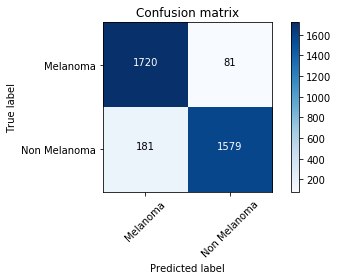

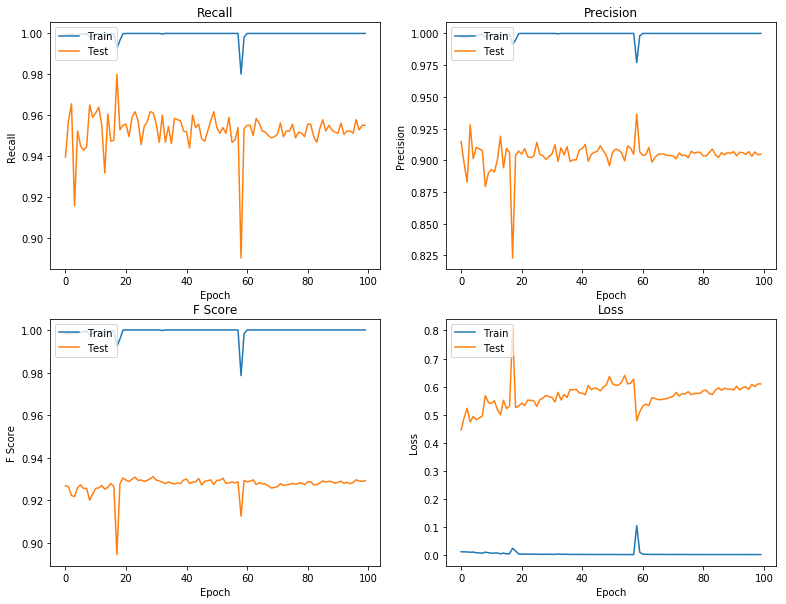

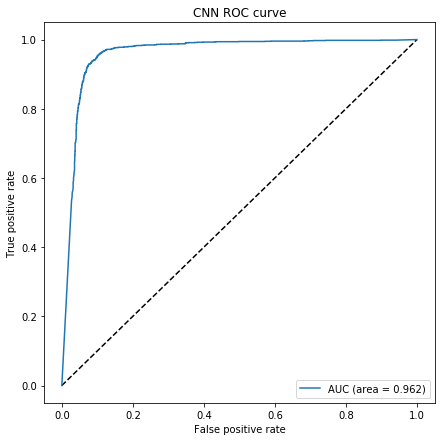

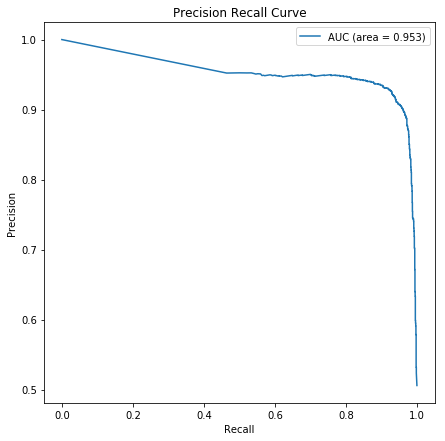

In [41]:
get_stats(model,historynew,validation_features_vgg,ytest)

3561/3561 [==============================] - 1s 203us/step

Validation loss: 0.6090575414370406
Validation auc: 0.9615801888427096
Validation precision: 0.904786954187018
Validation recall: 0.9550249860657953
Validation F Score: 0.9292273946108122 

              precision    recall  f1-score   support

Non Melanoma       0.97      0.87      0.92      1760
    Melanoma       0.89      0.97      0.93      1801

   micro avg       0.92      0.92      0.92      3561
   macro avg       0.93      0.92      0.92      3561
weighted avg       0.93      0.92      0.92      3561

Confusion matrix


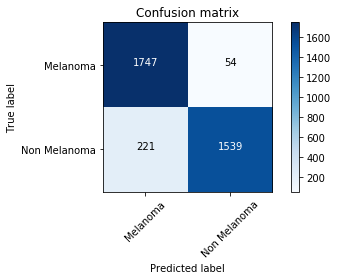

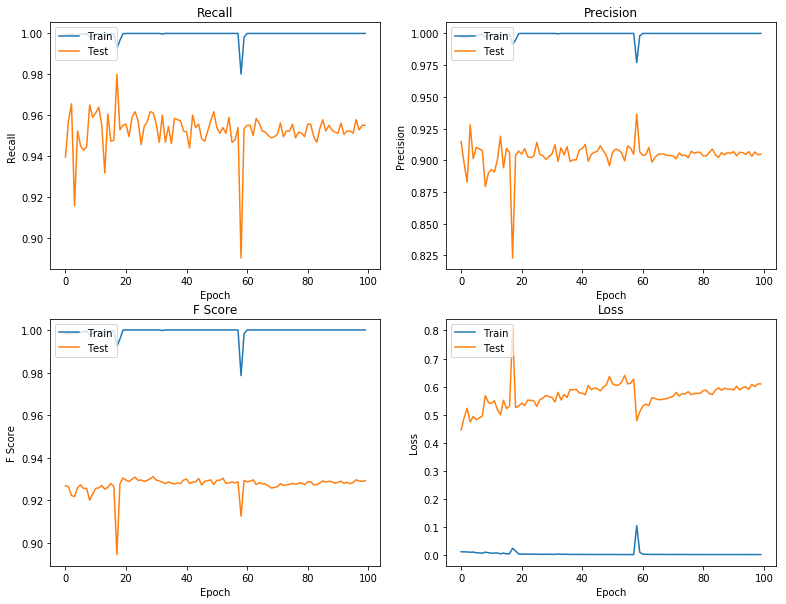

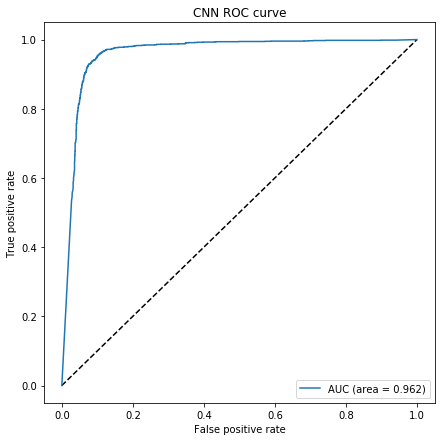

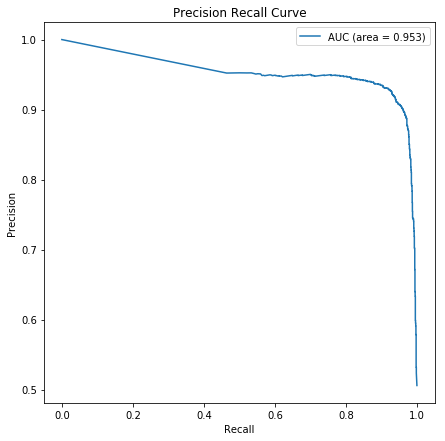

In [43]:
get_stats_thresh(model,historynew,validation_features_vgg,ytest,0.1)

In [11]:
# Adding one more maxpol and one more conv layer to upample replacement model

input_dims=(200,200,3)

def upsamp_min(df,target):


    df_minority = df[df[target]=='1']
    df_majority = df[df[target]=='0']

    len_majority = len(df[df[target]=='0'])

    df_minority_upsampled = resample(df_minority, 
                             replace=True,    # sample with replacement
                             n_samples = int(len_majority),     # resample to len of majority class
                             random_state=123) # reproducible results 

    # Combine minority class with downsampled majority class
    df = pd.concat([df_minority_upsampled, df_majority],ignore_index=True)

    return df
df=pd.read_pickle(r'C:\Users\Admin\OneDrive - mycit.ie\Documents\CIT\Semester 2\Final Project\PW Submission 1\200_200_new_ims.pkl')
target='class'
df = upsamp_min(df,target)

batch_size = 128
epochs = 50
num_classes = 1
input_shape = (200,200,3)
#class_weights={0: 1, 1: 4} class weight adjustment not needed now due to resampling

xtrain, xtest, ytrain, ytest = train_test(df)

# dataframe no longer needed
del df


xtrain,xtest = norm_255(xtrain,xtest)

Training set balance:
 1    7169
0    7074
Name: class, dtype: int64
Test set balance:
 0    1828
1    1733
Name: class, dtype: int64


In [13]:
input_shape = (200,200,3)

def createModel(input_shape,num_classes):

    
    model = Sequential()

    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Flatten())
    
    model.add(Dense(512, activation='relu'))

    model.add(Dense(256, activation='relu'))
    
    model.add(Dense(num_classes, activation='sigmoid'))
    
    #adam = Adam(lr=0.0001)
    #adam = Adam(lr=1e-3, decay=1e-3 / 200)
    
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=[auroc,km.binary_precision(), km.binary_recall(),km.binary_f1_score()])
    
    return model


# same batch size and epochs

model3 = createModel(input_shape,num_classes)

datagen = ImageDataGenerator(
    zoom_range=0.2,          # randomly zoom into images
    rotation_range=90,      # randomly rotate images in the range (degrees, 0 to 180). 
    width_shift_range=0.1,   # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,    # randomly flip images
    vertical_flip=True)      # randomly flip images

# set up model checkpoint
#save_dir = r'C:\Users\Admin\OneDrive - mycit.ie\Documents\CIT\Semester 2\Final Project\Latest Models\Saved_Mods'
save_path = 'more_layers.hdf5'

# save highest AUC out of all epochs (can also monitor recall,precision and f-score)
checkpoint = ModelCheckpoint(save_path, monitor='val_f1_score', verbose=1, save_best_only=True, mode='max')

# reduce learning rate if AUC stagnates
reduce_lr = ReduceLROnPlateau(monitor='val_f1_score', factor=0.2,patience=5, min_lr=0.0001)

# Fit the model on the images. removed class weights parameter - dataset is now balanced due to upsampling
history3 = model3.fit_generator(datagen.flow(xtrain, ytrain, batch_size=batch_size),
                                steps_per_epoch=int(np.ceil(xtrain.shape[0] / float(batch_size))),
                                epochs=100,
                                validation_data=(xtest, ytest),
                                callbacks=[checkpoint,reduce_lr],
                                workers=7)

Epoch 1/100
112/112 [==============================] - 67s 599ms/step - loss: 0.4750 - auroc: 0.8472 - precision: 0.7394 - recall: 0.8328 - f1_score: 0.7833 - val_loss: 0.7153 - val_auroc: 0.8162 - val_precision: 0.5991 - val_recall: 0.9561 - val_f1_score: 0.7366

Epoch 00001: val_f1_score improved from -inf to 0.73661, saving model to more_layers.hdf5
Epoch 2/100
112/112 [==============================] - 55s 487ms/step - loss: 0.4173 - auroc: 0.8831 - precision: 0.7666 - recall: 0.8590 - f1_score: 0.8102 - val_loss: 0.4613 - val_auroc: 0.8625 - val_precision: 0.6999 - val_recall: 0.9192 - val_f1_score: 0.7947

Epoch 00002: val_f1_score improved from 0.73661 to 0.79471, saving model to more_layers.hdf5
Epoch 3/100
112/112 [==============================] - 57s 510ms/step - loss: 0.4050 - auroc: 0.8924 - precision: 0.7740 - recall: 0.8620 - f1_score: 0.8157 - val_loss: 0.4885 - val_auroc: 0.8557 - val_precision: 0.7262 - val_recall: 0.8679 - val_f1_score: 0.7907

Epoch 00003: val_f1_sc

112/112 [==============================] - 55s 492ms/step - loss: 0.2851 - auroc: 0.9465 - precision: 0.8434 - recall: 0.9148 - f1_score: 0.8776 - val_loss: 0.2987 - val_auroc: 0.9409 - val_precision: 0.8439 - val_recall: 0.8950 - val_f1_score: 0.8687

Epoch 00025: val_f1_score improved from 0.86821 to 0.86866, saving model to more_layers.hdf5
Epoch 26/100
112/112 [==============================] - 56s 497ms/step - loss: 0.2820 - auroc: 0.9476 - precision: 0.8475 - recall: 0.9106 - f1_score: 0.8779 - val_loss: 0.2990 - val_auroc: 0.9433 - val_precision: 0.8177 - val_recall: 0.9319 - val_f1_score: 0.8711

Epoch 00026: val_f1_score improved from 0.86866 to 0.87109, saving model to more_layers.hdf5
Epoch 27/100
112/112 [==============================] - 58s 522ms/step - loss: 0.2817 - auroc: 0.9480 - precision: 0.8473 - recall: 0.9177 - f1_score: 0.8811 - val_loss: 0.2950 - val_auroc: 0.9430 - val_precision: 0.8224 - val_recall: 0.9221 - val_f1_score: 0.8694

Epoch 00027: val_f1_score did

112/112 [==============================] - 60s 533ms/step - loss: 0.2320 - auroc: 0.9647 - precision: 0.8746 - recall: 0.9365 - f1_score: 0.9045 - val_loss: 0.2825 - val_auroc: 0.9502 - val_precision: 0.8344 - val_recall: 0.9446 - val_f1_score: 0.8861

Epoch 00050: val_f1_score did not improve from 0.89653
Epoch 51/100
112/112 [==============================] - 56s 503ms/step - loss: 0.2308 - auroc: 0.9650 - precision: 0.8768 - recall: 0.9385 - f1_score: 0.9066 - val_loss: 0.2736 - val_auroc: 0.9514 - val_precision: 0.8639 - val_recall: 0.9158 - val_f1_score: 0.8891

Epoch 00051: val_f1_score did not improve from 0.89653
Epoch 52/100
112/112 [==============================] - 63s 567ms/step - loss: 0.2290 - auroc: 0.9659 - precision: 0.8772 - recall: 0.9385 - f1_score: 0.9068 - val_loss: 0.2574 - val_auroc: 0.9564 - val_precision: 0.8566 - val_recall: 0.9446 - val_f1_score: 0.8985

Epoch 00052: val_f1_score improved from 0.89653 to 0.89846, saving model to more_layers.hdf5
Epoch 53/100

112/112 [==============================] - 60s 540ms/step - loss: 0.1942 - auroc: 0.9752 - precision: 0.9013 - recall: 0.9499 - f1_score: 0.9250 - val_loss: 0.3067 - val_auroc: 0.9474 - val_precision: 0.8415 - val_recall: 0.9250 - val_f1_score: 0.8813

Epoch 00075: val_f1_score did not improve from 0.90944
Epoch 76/100
112/112 [==============================] - 59s 530ms/step - loss: 0.1894 - auroc: 0.9763 - precision: 0.9042 - recall: 0.9516 - f1_score: 0.9273 - val_loss: 0.2453 - val_auroc: 0.9613 - val_precision: 0.8636 - val_recall: 0.9423 - val_f1_score: 0.9012

Epoch 00076: val_f1_score did not improve from 0.90944
Epoch 77/100
112/112 [==============================] - 60s 539ms/step - loss: 0.1888 - auroc: 0.9763 - precision: 0.9035 - recall: 0.9506 - f1_score: 0.9265 - val_loss: 0.2391 - val_auroc: 0.9624 - val_precision: 0.8729 - val_recall: 0.9515 - val_f1_score: 0.9105

Epoch 00077: val_f1_score improved from 0.90944 to 0.91055, saving model to more_layers.hdf5
Epoch 78/100

112/112 [==============================] - 59s 523ms/step - loss: 0.1609 - auroc: 0.9839 - precision: 0.9183 - recall: 0.9629 - f1_score: 0.9401 - val_loss: 0.2302 - val_auroc: 0.9667 - val_precision: 0.9017 - val_recall: 0.9048 - val_f1_score: 0.9032

Epoch 00100: val_f1_score did not improve from 0.92350


3561/3561 [==============================] - 6s 2ms/step

Validation loss: 0.20727642088484075
Validation auc: 0.9722553663930315
Validation precision: 0.8826933192591955
Validation recall: 0.9682631274686518
Validation F Score: 0.9235002252349043 

              precision    recall  f1-score   support

Non Melanoma       0.97      0.88      0.92      1828
    Melanoma       0.88      0.97      0.92      1733

   micro avg       0.92      0.92      0.92      3561
   macro avg       0.92      0.92      0.92      3561
weighted avg       0.93      0.92      0.92      3561

Confusion matrix


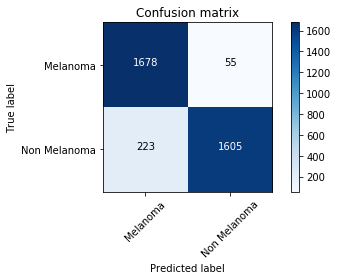

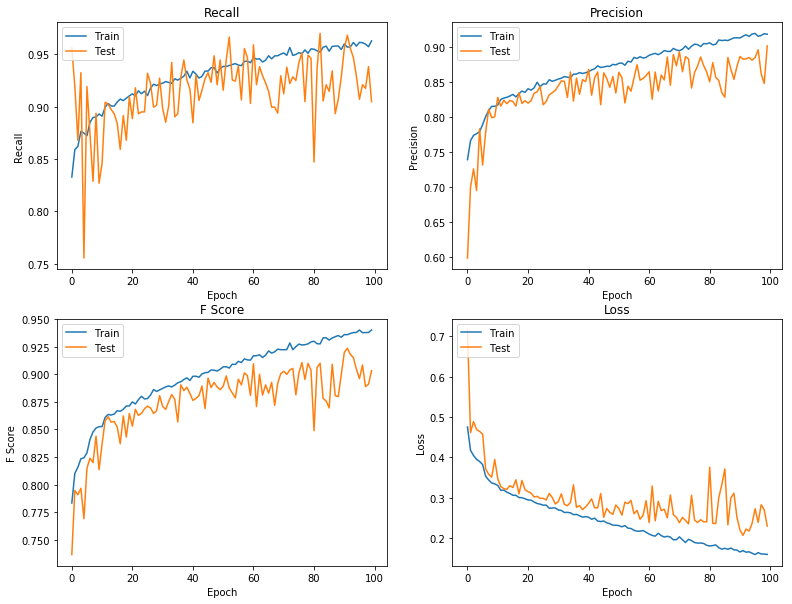

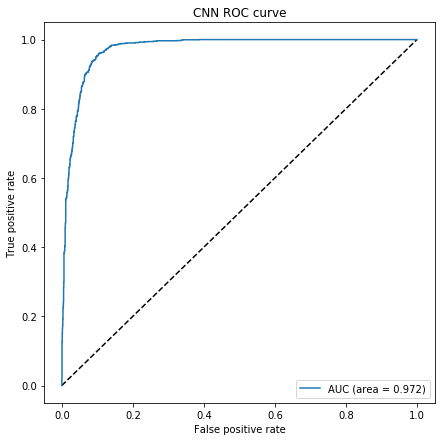

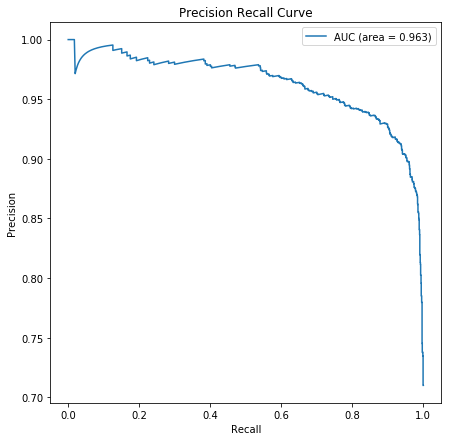

In [15]:
# reload best model - initialize model again
model3 = createModel(input_shape,num_classes)

#load weights
model3.load_weights('more_layers.hdf5')

get_stats_thresh(model3,history3,xtest,ytest,0.5)